In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime

In [5]:
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [6]:
df = pd.read_csv('cleaned1219.csv')

In [7]:
df.head()

,DISSEMINATION_ID,ORIGINAL_DISSEMINATION_ID,ACTION,EXECUTION_TIMESTAMP,EFFECTIVE_DATE,END_DATE,TAXONOMY,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,Payment
0,1951179,NaN,NEW,2013-04-05 20:30:26,2013-04-06 00:00:00,2017-12-20 00:00:00,Credit:Index:CDX:CDXIG,77.80,75000000.0,0,583500.0
1,1965509,1930221.0,CANCEL,2013-04-05 19:08:09,2013-03-20 00:00:00,2018-06-20 00:00:00,Credit:Index:CDX:CDXIG,87.50,50000000.0,0,437500.0
2,1965533,1929625.0,CANCEL,2013-04-05 19:09:26,2013-03-20 00:00:00,2018-06-20 00:00:00,Credit:Index:CDX:CDXIG,87.50,50000000.0,0,437500.0
3,1965714,1920116.0,CANCEL,2013-04-05 14:22:14,2013-03-20 00:00:00,2018-06-20 00:00:00,Credit:Index:CDX:CDXIG,88.75,75000000.0,0,665625.0
4,1965721,1917181.0,CANCEL,2013-04-05 12:47:34,2013-03-20 00:00:00,2018-06-20 00:00:00,Credit:Index:CDX:CDXIG,89.25,50000000.0,0,446250.0


## Data Aggregation

In [38]:
# only keep columns that are meaningful (not include columns that: all cleared, all ACT/360 and all USD, all between 4.5-5.5 years bond)
df = df[['ACTION','EXECUTION_TIMESTAMP','TAXONOMY','PRICE_NOTATION','ROUNDED_NOTIONAL_AMOUNT_1','EXCEEDS_ROUNDED_NOTIONAL_AMOUNT','Payment']]

In [39]:
# encoding for categorical columns
df = df.join(pd.get_dummies(df['ACTION']))
df = df.drop('ACTION',axis=1)
df = df.join(pd.get_dummies(df['TAXONOMY']))
df = df.drop('TAXONOMY',axis=1)

In [40]:
# convert timestamp to datetime object
df['EXECUTION_TIMESTAMP'] = pd.to_datetime(df['EXECUTION_TIMESTAMP'])

In [41]:
# set index as timestamp for future resampling
df = df.set_index('EXECUTION_TIMESTAMP')

In [42]:
# work on taxonomy: HY only 
df_HY = df[df['Credit:Index:CDX:CDXHY'] == 1]

In [43]:
df_HY = df_HY.drop('Credit:Index:CDX:CDXHY', axis = 1)

In [44]:
df_HY = df_HY.drop('Credit:Index:CDX:CDXIG', axis = 1)

In [45]:
# since we download data after 2012, remove rows with execution_timestamp < 2012
df_HY = df_HY[df_HY.index >= datetime(2012,1,1)]

In [46]:
# resample data into 1 day frequency, with numerical columns take mean and encoding categorical columns take sum
bucket_HY = df_HY.resample('1D').agg({'PRICE_NOTATION':'mean', 'ROUNDED_NOTIONAL_AMOUNT_1':'mean', 'Payment':'mean',
                            "EXCEEDS_ROUNDED_NOTIONAL_AMOUNT":"sum", "CANCEL":"sum","CORRECT":"sum", "NEW":"sum"})

In [47]:
bucket_HY.head()

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW
EXECUTION_TIMESTAMP,,,,,,,
2013-03-15,92.5625,6500000.0,610625000.0,0,2,0,0.0
2013-03-16,NaN,NaN,NaN,0,0,0,0.0
2013-03-17,NaN,NaN,NaN,0,0,0,0.0
2013-03-18,NaN,NaN,NaN,0,0,0,0.0
2013-03-19,NaN,NaN,NaN,0,0,0,0.0


In [48]:
# add a column for number of observations in each bucket, i.e. trading volumn
bucket_HY['Number_of_observations'] = df_HY.resample('1D').count()['PRICE_NOTATION']

In [49]:
bucket_HY['Payment_std'] = df_HY.resample('1D').apply(lambda x: x['Payment'].std())

In [50]:
bucket_HY['Payment_min'] = df_HY.resample('1D').apply(lambda x: x['Payment'].min())

In [51]:
bucket_HY['Payment_max'] = df_HY.resample('1D').apply(lambda x: x['Payment'].max())

In [52]:
bucket_HY.tail() # find out null values normally occur on weekends and Monday 

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,Payment_std,Payment_min,Payment_max
EXECUTION_TIMESTAMP,,,,,,,,,,,
2019-04-05,107.167187,2.419585e+07,2.594310e+09,10,4,2,201.0,207,2.927349e+09,23735021.2,1.177330e+10
2019-04-06,NaN,NaN,NaN,0,0,0,0.0,0,NaN,NaN,NaN
2019-04-07,NaN,NaN,NaN,0,0,0,0.0,0,NaN,NaN,NaN
2019-04-08,106.878238,1.687946e+07,1.804218e+09,2,1,0,111.0,112,1.997625e+09,53495000.0,1.186625e+10
2019-04-09,106.953991,1.574663e+07,1.686503e+09,3,3,3,162.0,168,1.897307e+09,5775300.0,1.175845e+10


In [53]:
# count how many null values
bucket_HY.isnull().sum()

PRICE_NOTATION                     709
ROUNDED_NOTIONAL_AMOUNT_1          709
Payment                            709
EXCEEDS_ROUNDED_NOTIONAL_AMOUNT      0
CANCEL                               0
CORRECT                              0
NEW                                  0
Number_of_observations               0
Payment_std                        711
Payment_min                        709
Payment_max                        709
dtype: int64

In [54]:
# null values approximately 30% if using 1 day resample frequency
bucket_HY['PRICE_NOTATION'].isnull().sum()/len(bucket_HY)

0.31980153360396935

In [55]:
# since we assume correct and cancel happen within short period of time, 
# and assume number of 'CANCEL' >= number of 'CORRECT'
# however, since we divide groups to 1 day period, the original continuous time been divided into discrete buckets
# so the marginal(split point) can affect how 'new', 'cancel' and 'correct' distribute into buckets 
# therefore result in 'correct' numbers greater than 'cancel'
bucket_HY.loc[bucket_HY['CORRECT'] > bucket_HY['CANCEL']]

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,Payment_std,Payment_min,Payment_max
EXECUTION_TIMESTAMP,,,,,,,,,,,
2013-04-29,110.649233,1.858136e+07,2.008852e+09,3,4,6,49.0,59,2.360646e+09,0.0,1.068750e+10
2013-05-06,112.168304,2.194870e+07,2.398951e+09,1,4,9,41.0,54,2.135239e+09,0.0,1.066875e+10
2013-05-08,113.563025,1.580344e+07,1.862312e+09,0,2,4,90.0,96,2.714282e+09,0.0,2.500000e+10
2013-06-17,106.248871,2.118380e+07,2.232015e+09,5,11,73,82.0,166,2.203250e+09,57206250.0,1.041210e+10
2013-07-01,99.498630,2.335296e+07,2.330936e+09,4,12,20,103.0,135,2.415076e+09,0.0,1.034202e+10
2014-03-18,107.528807,2.047867e+07,2.200162e+09,3,10,11,227.0,248,2.010245e+09,15084300.0,1.182184e+10
2014-04-01,107.726413,2.929319e+07,3.160050e+09,16,10,11,176.0,197,3.084098e+09,1935900.0,1.081200e+10
2014-04-17,107.082448,2.200639e+07,2.358113e+09,3,1,2,105.0,108,2.407929e+09,26777500.0,1.182500e+10
2014-04-23,106.627831,2.419530e+07,2.582457e+09,8,4,6,157.0,167,2.828185e+09,8031735.0,1.183875e+10


In [56]:
bucket_HY.loc[bucket_HY['CORRECT'] > bucket_HY['CANCEL'],'CANCEL'] = bucket_HY.loc[bucket_HY['CORRECT'] > bucket_HY['CANCEL'],'CORRECT']

In [57]:
# 'NEW' action and 'CANCLE'/'CORRECT' can happen within short period of time, but not necessarily
# if number of 'NEW' < number of 'CANCEL', set then equal
# since we may filter out the entry with 'New' in data cleaning step, 
# or the corresponding 'NEW' action happens out of date range of our dataset
bucket_HY.loc[bucket_HY['NEW'] < bucket_HY['CANCEL']]

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,Payment_std,Payment_min,Payment_max
EXECUTION_TIMESTAMP,,,,,,,,,,,
2013-03-15,92.562500,6.500000e+06,6.106250e+08,0,2,0,0.0,2,4.817165e+08,2.700000e+08,9.512500e+08
2013-04-03,103.295000,7.500000e+06,7.750750e+08,0,2,0,0.0,2,3.667409e+08,5.157500e+08,1.034400e+09
2013-04-04,103.720000,1.350000e+07,1.394355e+09,0,2,0,0.0,2,1.677109e+09,2.084600e+08,2.580250e+09
2013-04-05,102.998153,5.250000e+07,5.408590e+09,1,4,0,0.0,4,3.799004e+09,1.029600e+09,1.030626e+10
2013-10-07,104.718750,1.000000e+07,1.047188e+09,0,1,1,0.0,2,0.000000e+00,1.047188e+09,1.047188e+09
2013-10-08,104.346354,1.041667e+07,1.086849e+09,0,12,12,0.0,24,5.077227e+08,5.215625e+08,2.606250e+09
2013-10-09,104.287500,9.000000e+06,9.386875e+08,0,5,5,0.0,10,2.201748e+08,5.209375e+08,1.043750e+09
2013-10-10,105.070312,7.500000e+06,7.880859e+08,0,4,4,0.0,8,2.810002e+08,5.250000e+08,1.050938e+09
2013-10-11,161.910714,2.428571e+07,8.198482e+09,1,3,3,1.0,7,1.843442e+10,1.055625e+09,5.000000e+10


In [58]:
# create a column indicating those cancel only actions (no correction after cancellation)
# leave original 'CANCEL' column as a piece of information for RNN to train
bucket_HY['CANCEL_ONLY'] = bucket_HY['CANCEL'] - bucket_HY['CORRECT']

In [59]:
# 'CORRECT_ONLY' action is the same as number of 'CORRECT' in the bucket
bucket_HY['CORRECT_ONLY'] = bucket_HY['CORRECT']

In [60]:
# create a column with action not cancel or correct > 'NEW_ONLY' action
bucket_HY['NEW_ONLY'] = bucket_HY['NEW'] - bucket_HY['CORRECT_ONLY'] - bucket_HY['CANCEL_ONLY']

In [61]:
bucket_HY.loc[bucket_HY['NEW_ONLY'] <0 ,'NEW_ONLY'] = bucket_HY.loc[bucket_HY['NEW_ONLY'] <0 ,'NEW']

In [62]:
# create feature about date
bucket_HY['day'] = pd.DatetimeIndex(bucket_HY.index).day
bucket_HY['year'] = pd.DatetimeIndex(bucket_HY.index).year
bucket_HY['month'] = pd.DatetimeIndex(bucket_HY.index).month
bucket_HY['dayofweek'] = pd.DatetimeIndex(bucket_HY.index).dayofweek
bucket_HY['quarter'] = pd.DatetimeIndex(bucket_HY.index).quarter

In [63]:
bucket_HY.describe()

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,Payment_std,Payment_min,Payment_max,CANCEL_ONLY,CORRECT_ONLY,NEW_ONLY,day,year,month,dayofweek,quarter
count,1508.000000,1.508000e+03,1.508000e+03,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,1.506000e+03,1.508000e+03,1.508000e+03,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,107.620063,2.049820e+07,2.235569e+09,2.861976,4.124944,2.090212,68.341903,74.484889,2.585430e+09,5.796927e+07,1.187323e+10,2.034732,2.090212,64.232747,15.738836,2015.738836,6.486694,3.000451,2.495264
std,11.387378,6.410648e+06,8.420273e+08,8.957777,6.866914,4.167302,89.561620,96.048564,1.707592e+09,3.138704e+08,9.342780e+09,4.224324,4.167302,85.871814,8.810781,1.779570,3.446330,2.001241,1.118881
min,72.870417,2.000000e+06,2.047872e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-3.715250e+09,2.048522e+08,0.000000,0.000000,0.000000,1.000000,2013.000000,1.000000,0.000000,1.000000
25%,104.722875,1.643506e+07,1.748931e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1.893205e+09,1.045075e+07,1.027675e+10,0.000000,0.000000,0.000000,8.000000,2014.000000,3.000000,1.000000,1.000000
50%,106.536678,1.961777e+07,2.096584e+09,1.000000,1.000000,0.000000,49.000000,53.000000,2.311297e+09,2.142350e+07,1.069648e+10,0.000000,0.000000,46.000000,16.000000,2016.000000,6.000000,3.000000,2.000000
75%,107.652428,2.335241e+07,2.526096e+09,3.000000,6.000000,3.000000,86.000000,96.000000,2.833850e+09,5.343688e+07,1.090000e+10,2.000000,3.000000,80.000000,23.000000,2017.000000,9.000000,5.000000,3.000000
max,277.789311,1.000000e+08,1.059530e+10,247.000000,73.000000,73.000000,729.000000,765.000000,3.176653e+10,1.059530e+10,1.660800e+11,56.000000,73.000000,709.000000,31.000000,2019.000000,12.000000,6.000000,4.000000


In [64]:
bucket_HY.to_csv("HY_cleaned.csv", index = False)

In [27]:
# basically Saturday and Sunday has not trading record
bucket_HY.loc[bucket_HY['dayofweek'] == 5,'PRICE_NOTATION'].notnull().sum()

8

In [28]:
bucket_HY.loc[bucket_HY['dayofweek'] == 6,'PRICE_NOTATION'].notnull().sum()

2

In [29]:
subset = bucket_IG[['PRICE_NOTATION','ROUNDED_NOTIONAL_AMOUNT_1','Number_of_observations','quarter','dayofweek']]

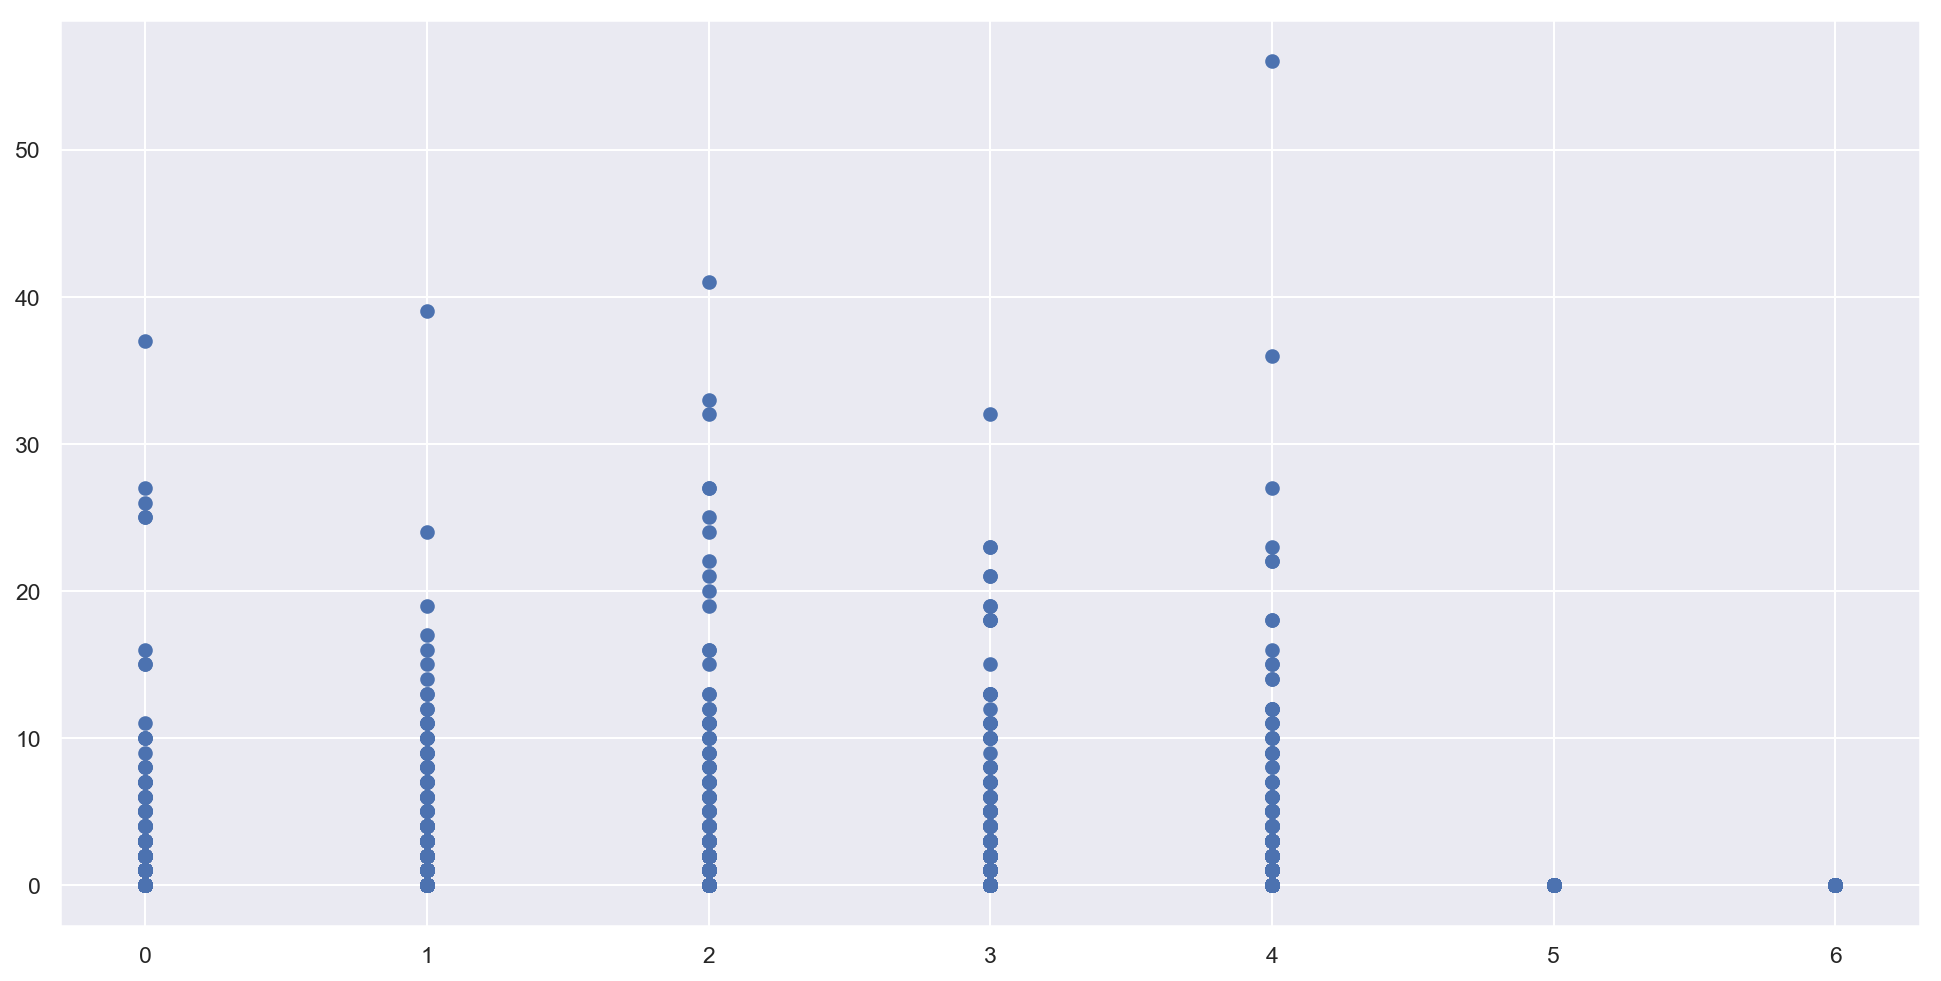

In [65]:
plt.scatter(x=bucket_HY['dayofweek'],y = bucket_HY['CANCEL_ONLY'])

Text(0.5, 1.0, 'Scatter Plot for Month VS Cancel only Action')

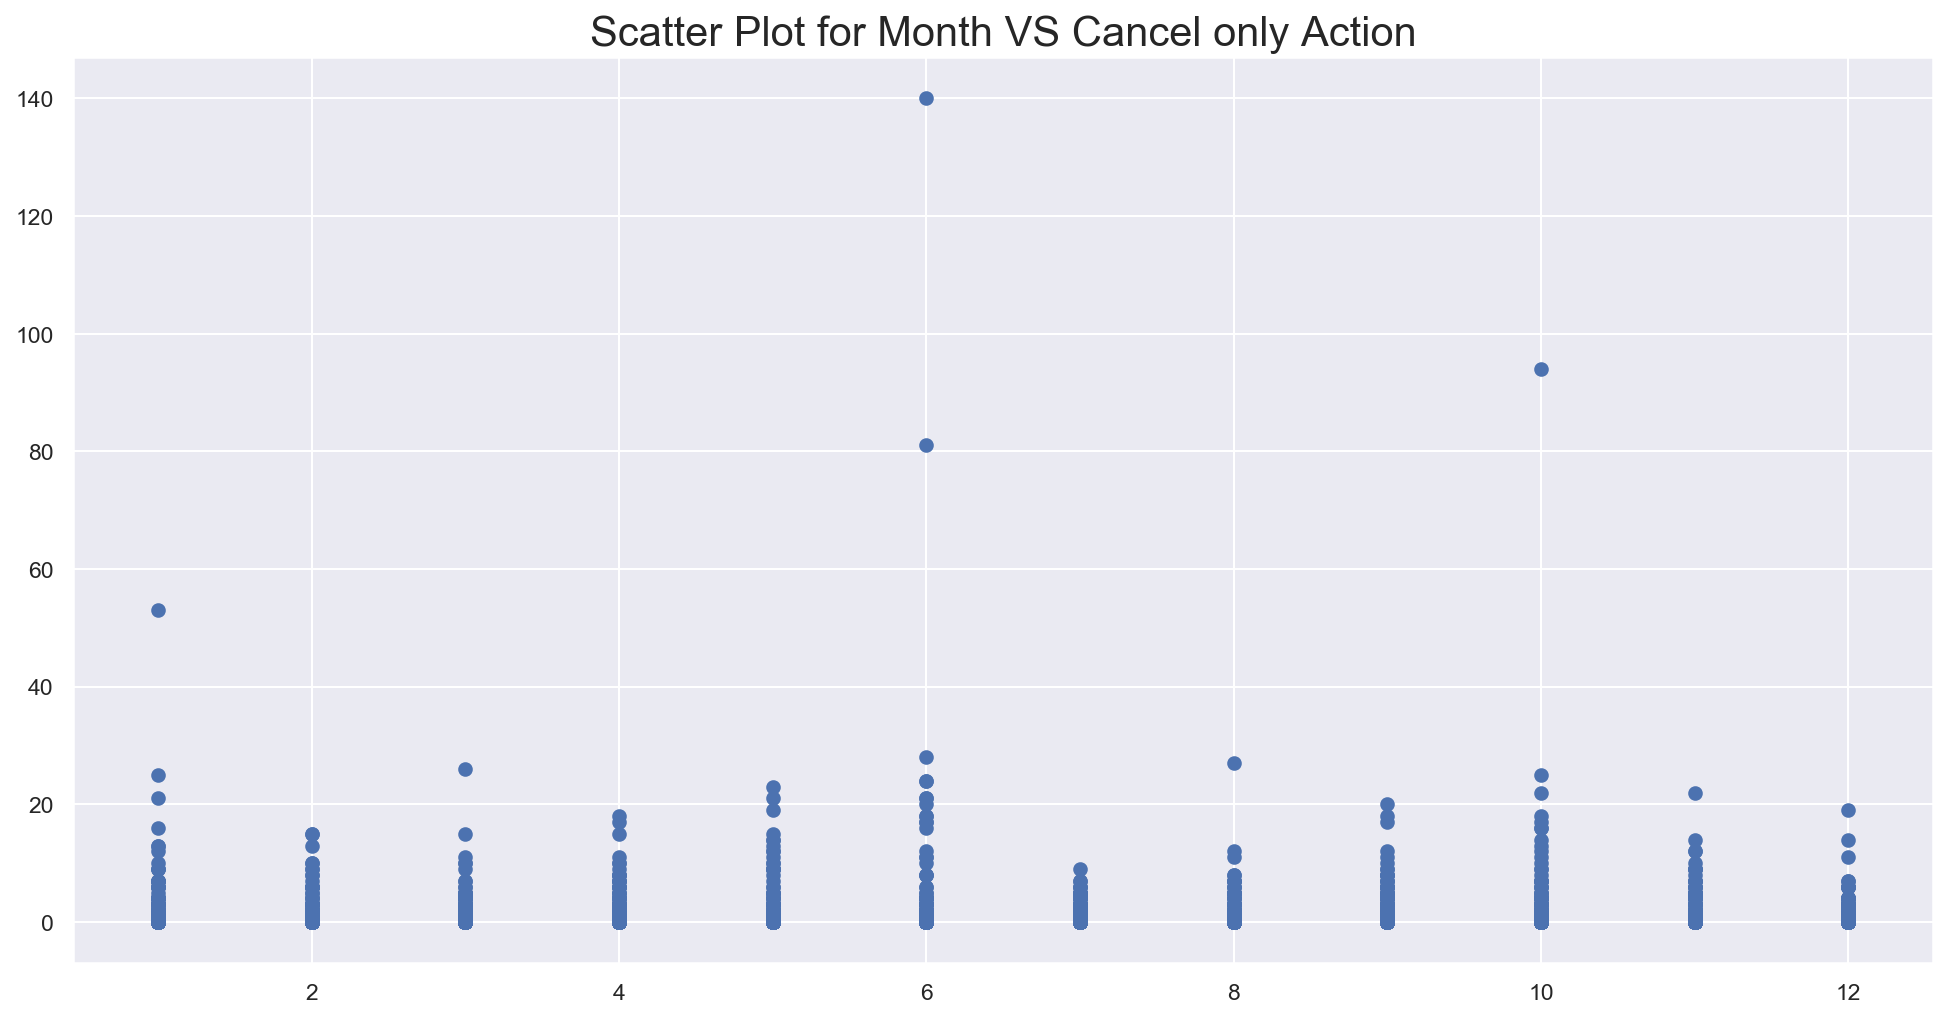

In [30]:
plt.scatter(x=bucket_IG['month'],y = bucket_IG['CANCEL_ONLY'])
plt.title("Scatter Plot for Month VS Cancel only Action",fontsize=20)
# want to keep the monthly distribution and basically all relationship same for the generated data

Text(0.5, 1.0, 'Scatter Plot for Month VS New only Action')

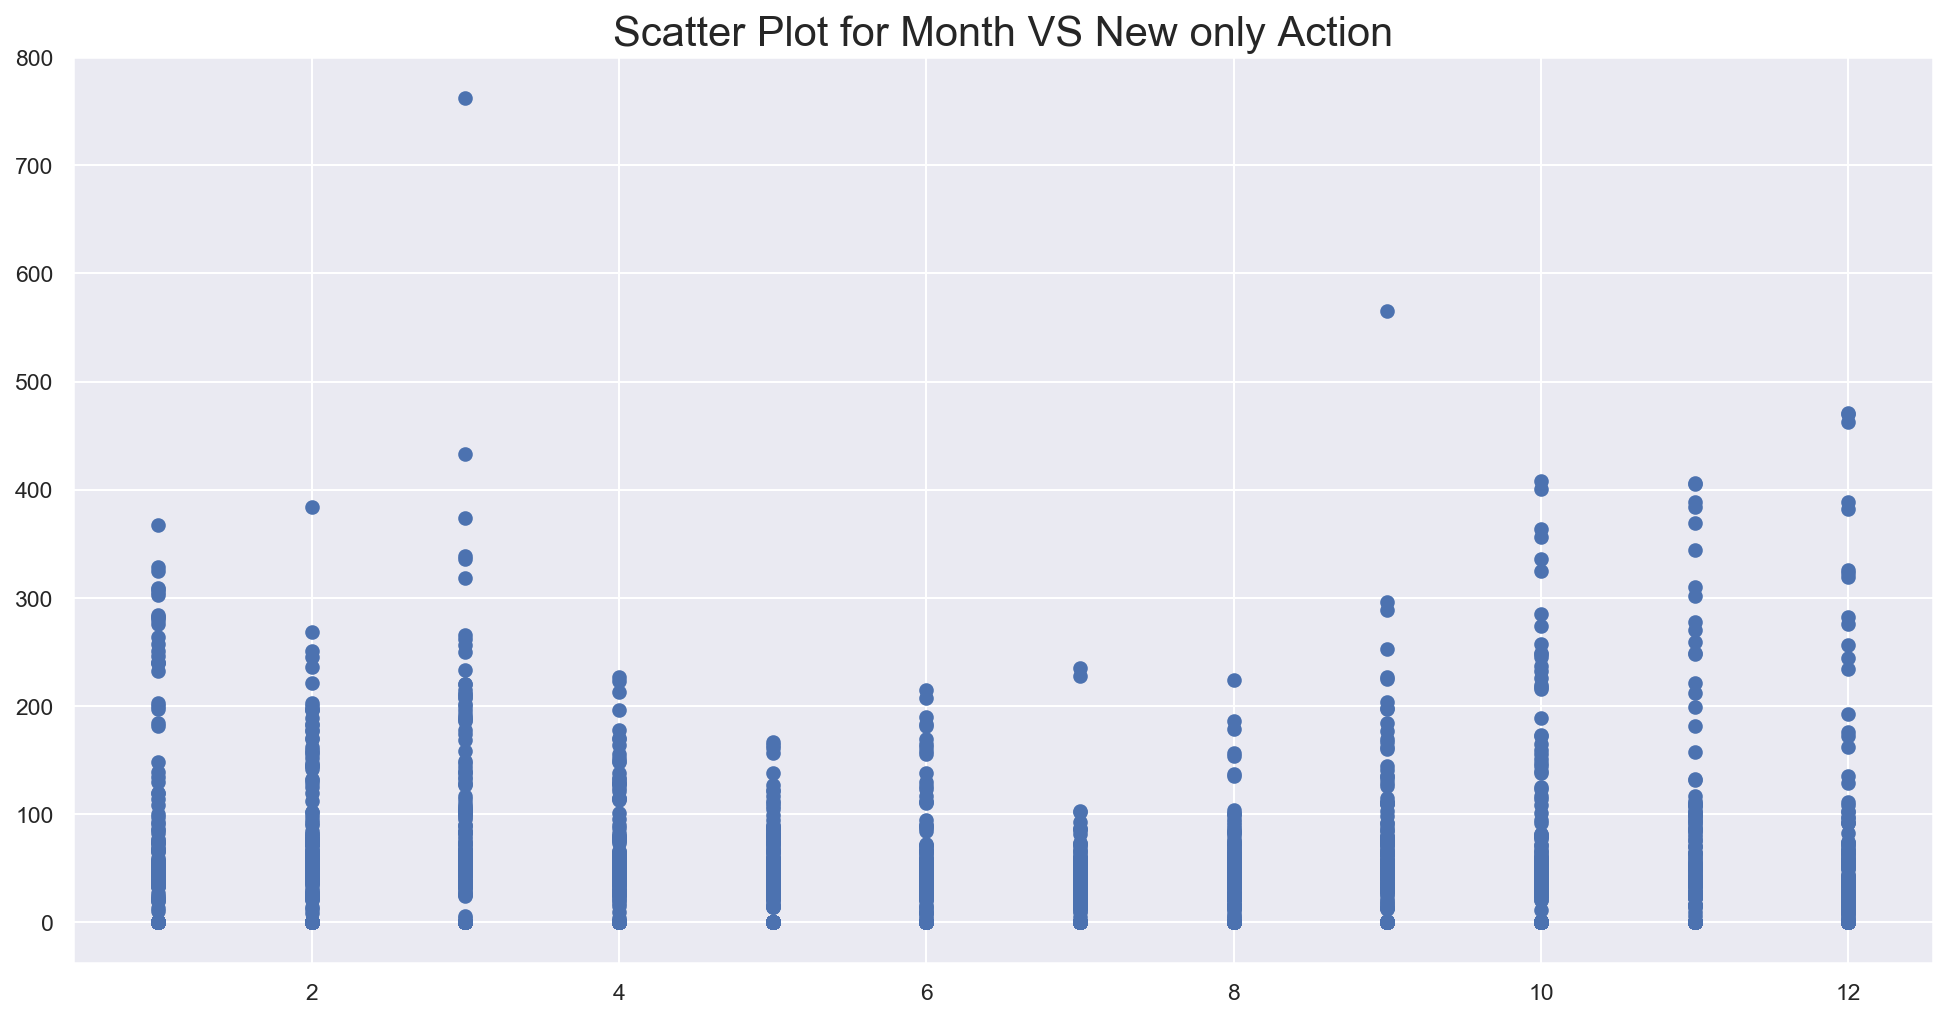

In [31]:
plt.scatter(x=bucket_IG['month'],y = bucket_IG['NEW_ONLY'])
plt.title("Scatter Plot for Month VS New only Action",fontsize=20)

Text(0.5, 1.0, 'Scatter Plot for Month VS Correct only Action')

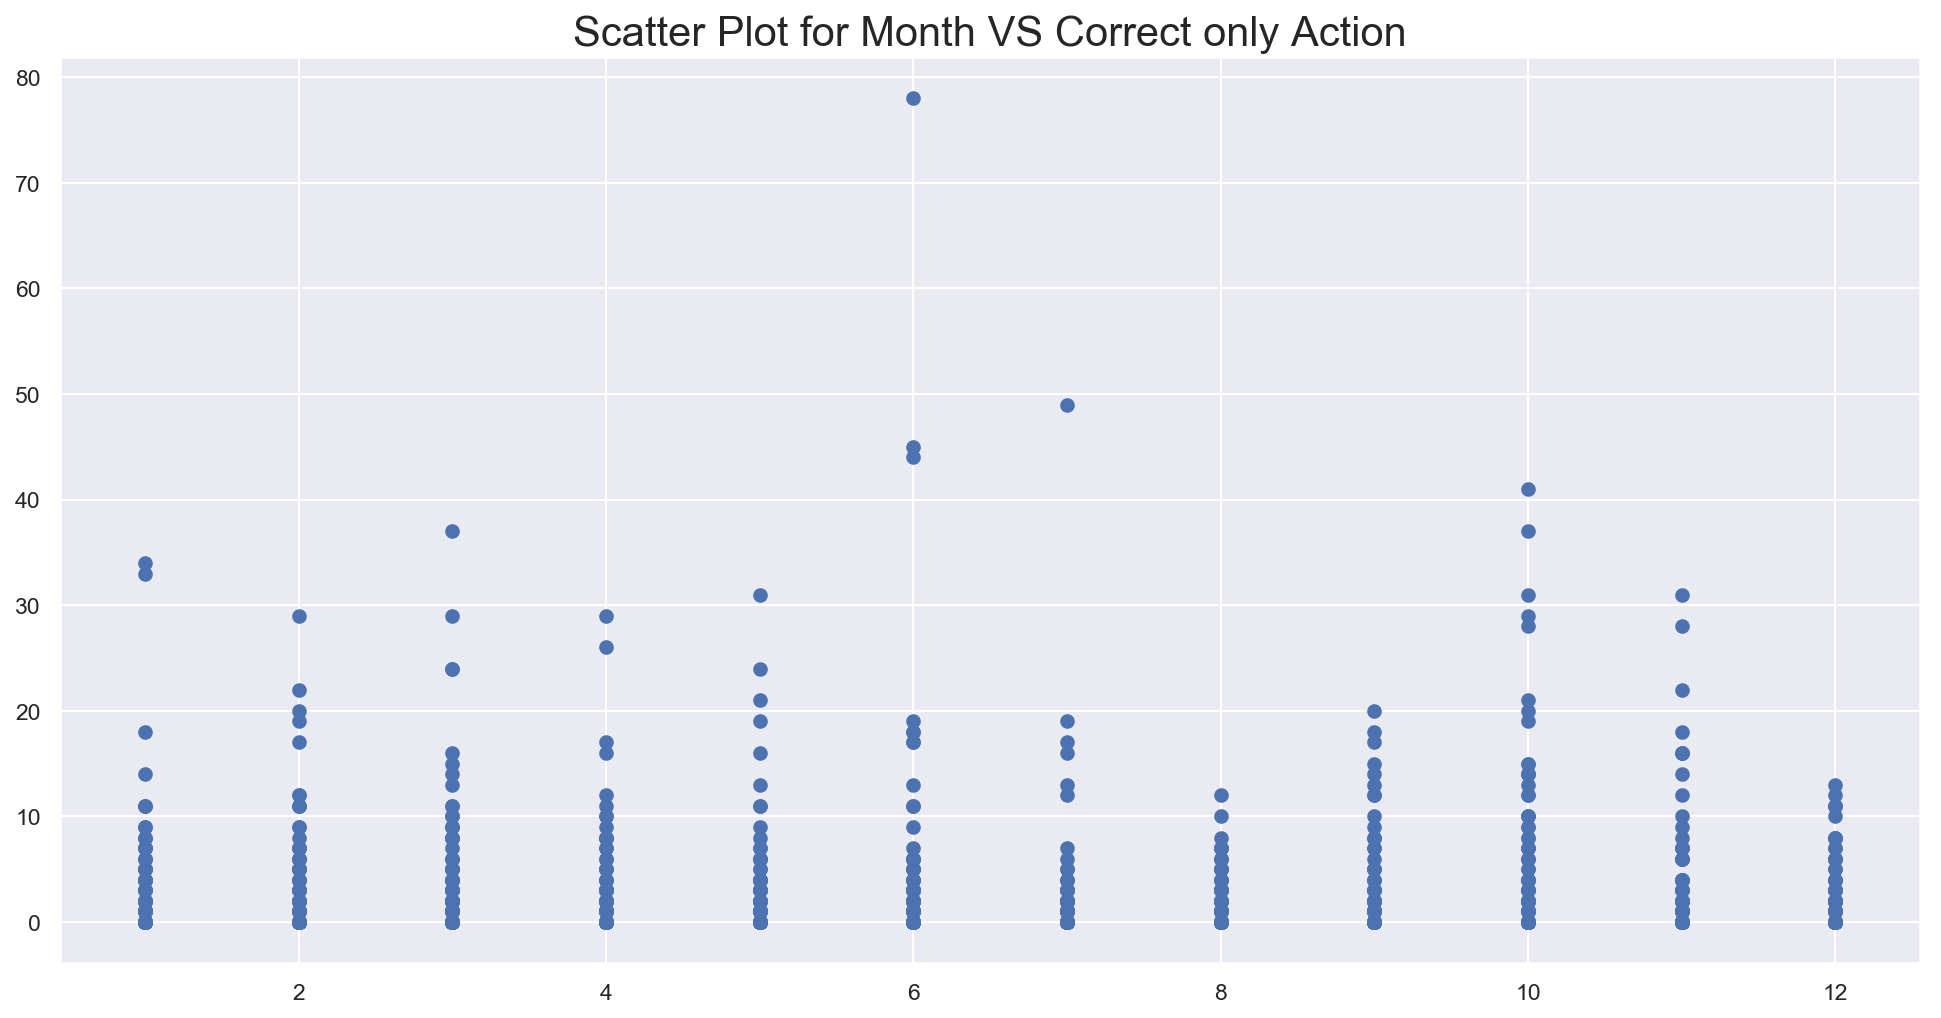

In [32]:
plt.scatter(x=bucket_IG['month'],y = bucket_IG['CORRECT_ONLY'])
plt.title("Scatter Plot for Month VS Correct only Action",fontsize=20)

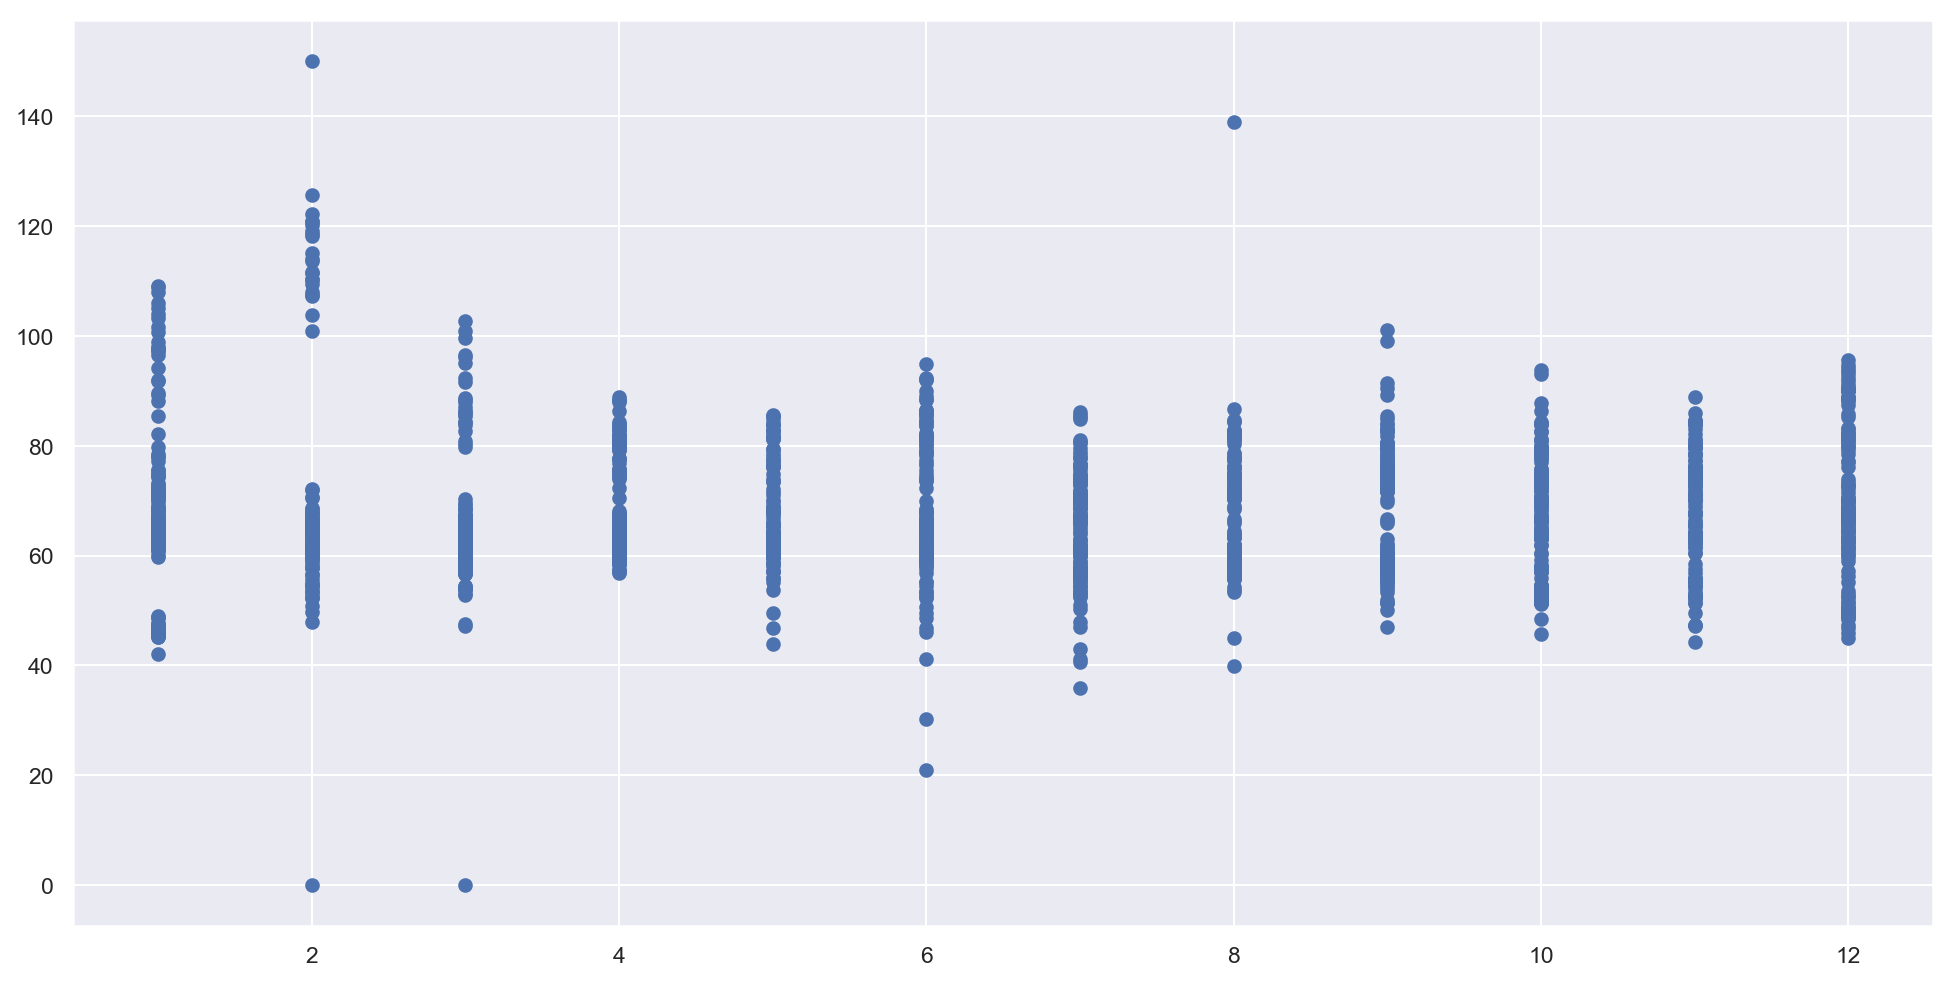

In [33]:
plt.scatter(x=bucket_IG['month'],y = bucket_IG['PRICE_NOTATION'])

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Payment Distribution for the whole dataset')

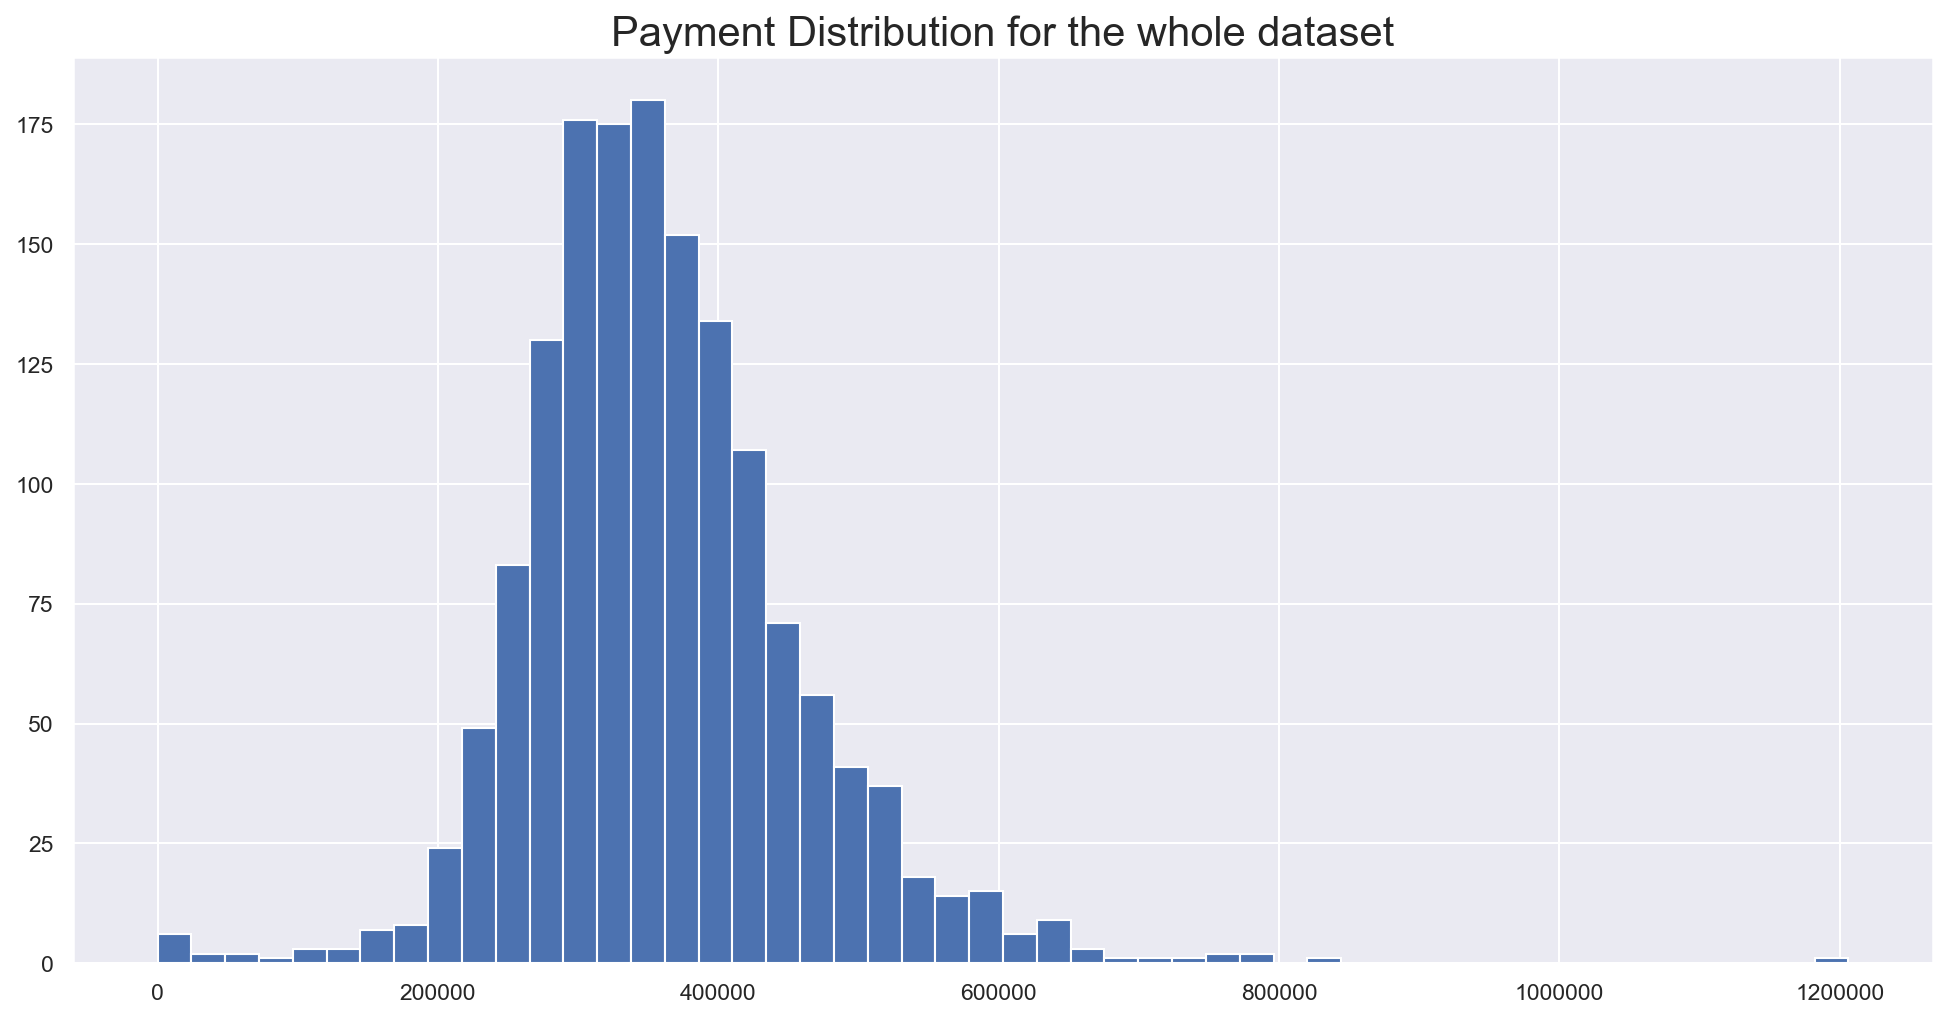

In [34]:
plt.hist(bucket_IG['Payment'], bins=50)
plt.title("Payment Distribution for the whole dataset",fontsize=20)

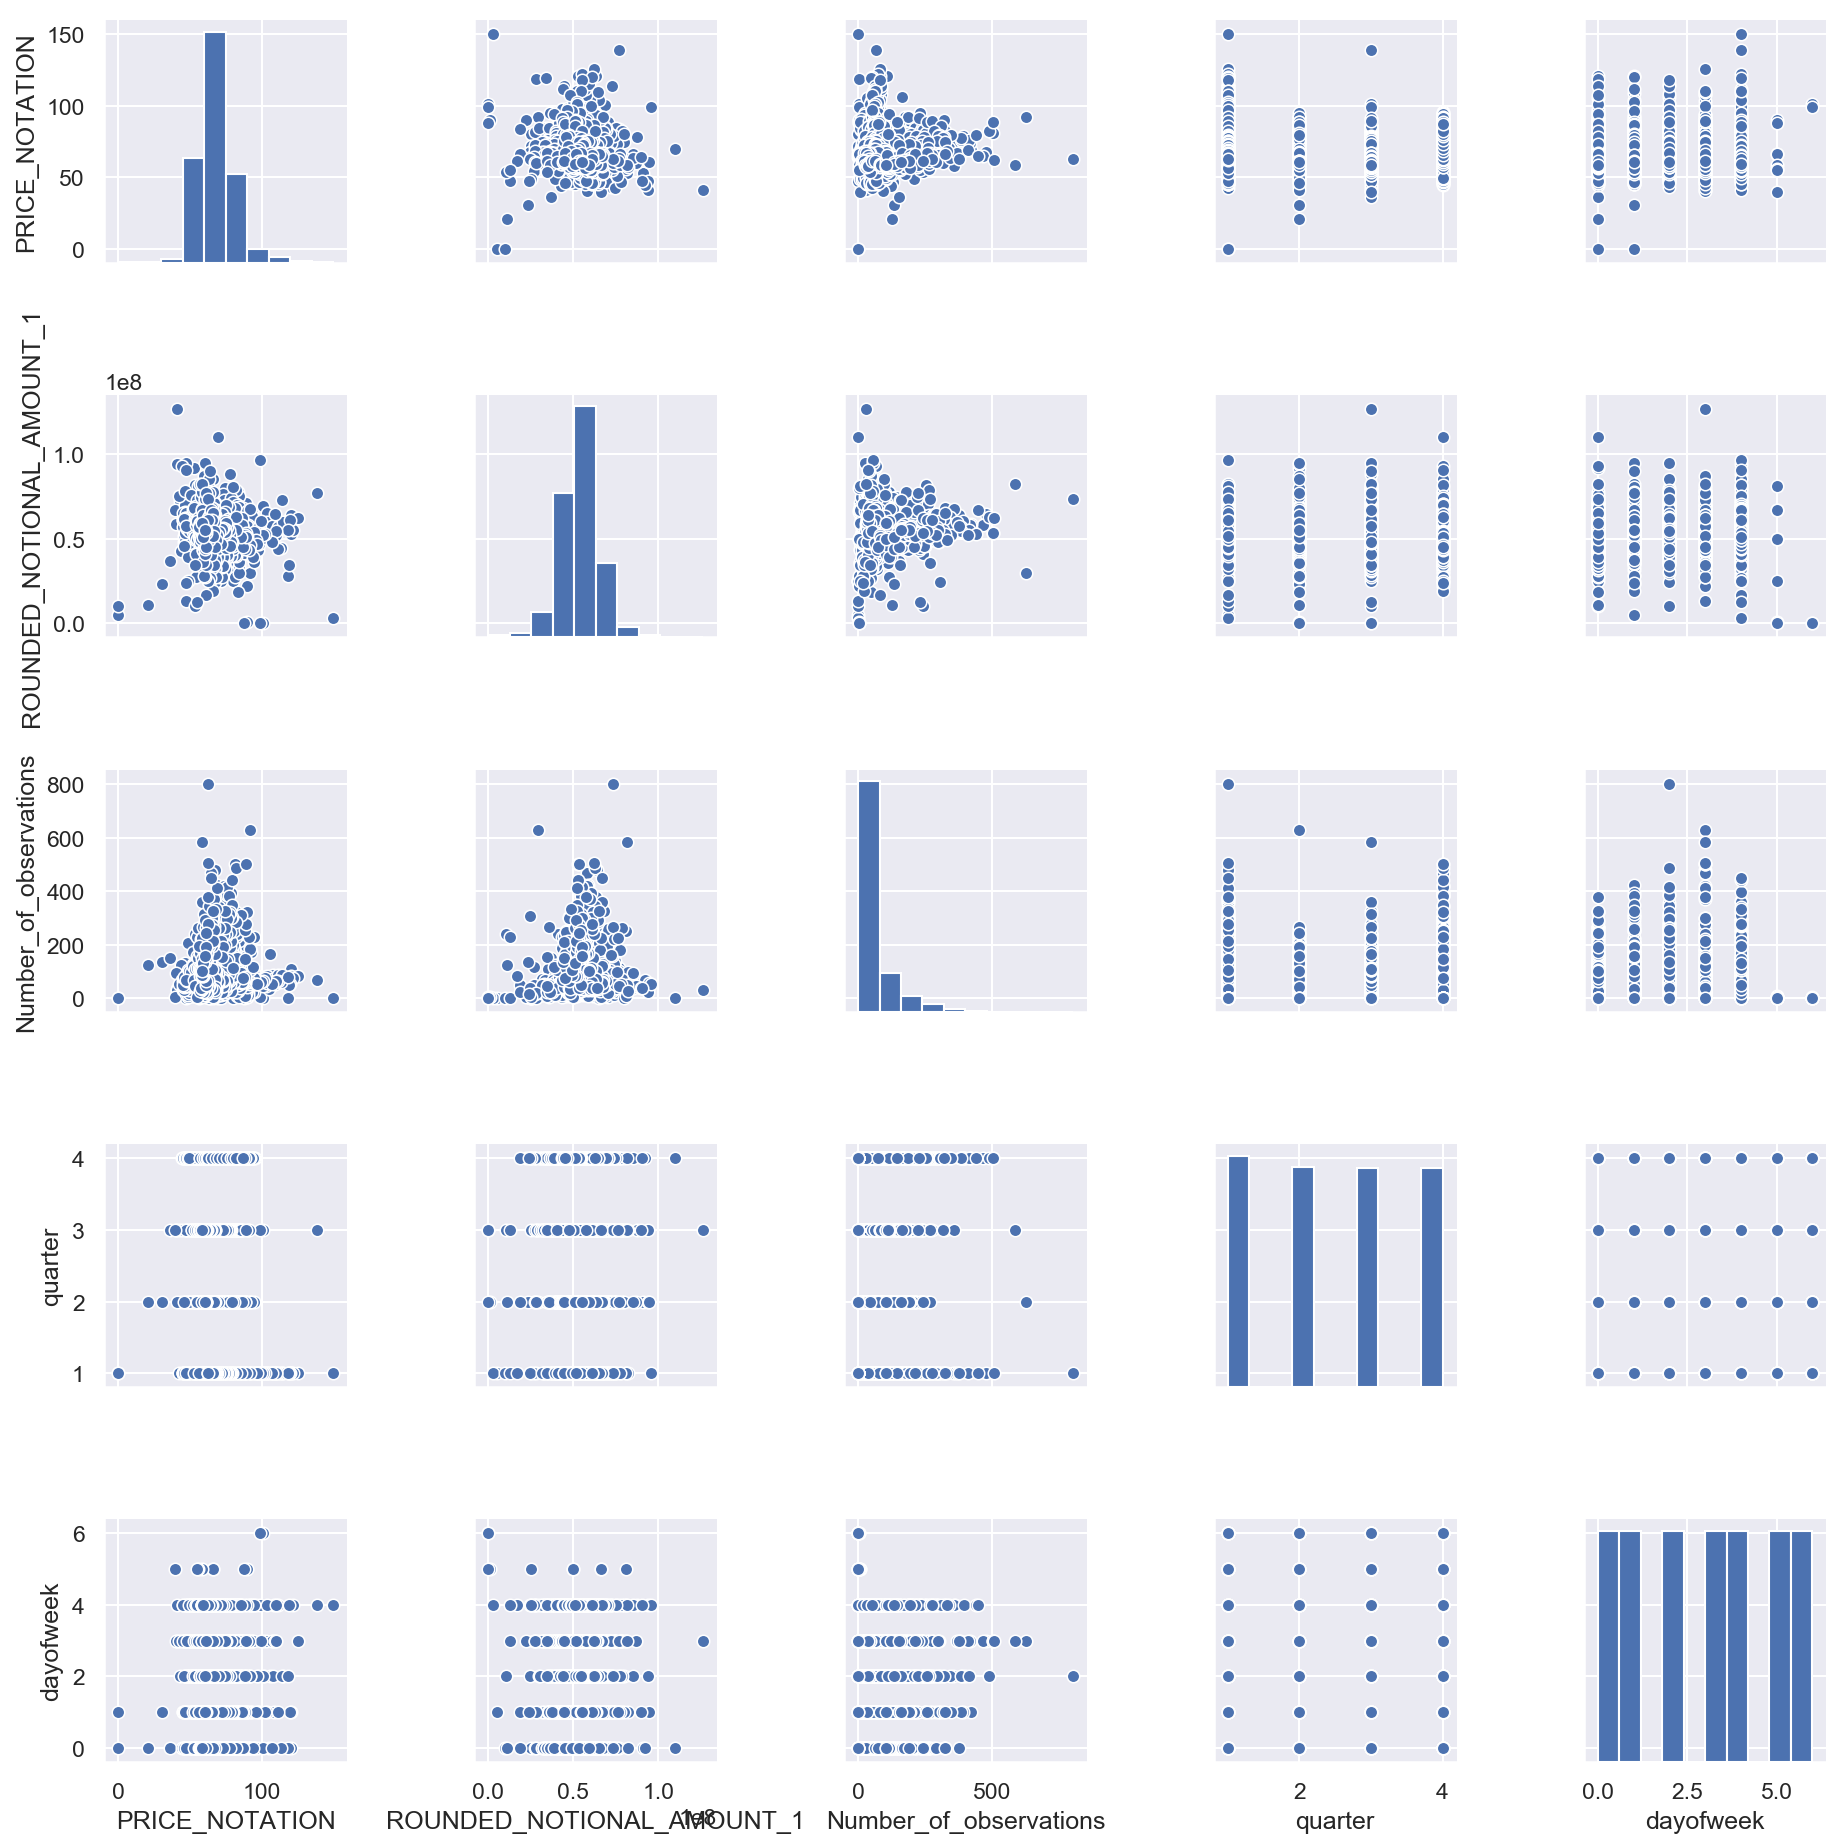

In [35]:
sns.pairplot(subset)

In [36]:
bucket_IG.corr()

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,CANCEL_ONLY,CORRECT_ONLY,NEW_ONLY,day,year,month,dayofweek,quarter
PRICE_NOTATION,1.000000,-0.071727,0.623843,0.078980,-0.008527,-0.136765,0.101774,0.084658,0.108806,-0.136765,0.107054,-0.008073,-0.203690,-0.012231,0.031548,-0.014526
ROUNDED_NOTIONAL_AMOUNT_1,-0.071727,1.000000,0.676064,0.345217,0.114732,0.132256,0.144270,0.156233,0.055673,0.132256,0.134599,-0.008098,-0.083076,-0.034095,-0.002161,-0.019855
Payment,0.623843,0.676064,1.000000,0.336562,0.088423,0.008847,0.205160,0.201229,0.125728,0.008847,0.201896,-0.007183,-0.214441,-0.037470,0.005455,-0.030566
EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,0.078980,0.345217,0.336562,1.000000,0.472040,0.403212,0.877951,0.881107,0.367817,0.403212,0.865284,0.033720,0.098340,-0.030123,-0.260293,-0.044365
CANCEL,-0.008527,0.114732,0.088423,0.472040,1.000000,0.791131,0.451145,0.558741,0.835809,0.791131,0.364023,0.013625,-0.147161,-0.006082,-0.216689,-0.007009
CORRECT,-0.136765,0.132256,0.008847,0.403212,0.791131,1.000000,0.387995,0.487370,0.325428,1.000000,0.326304,-0.004480,-0.043972,-0.012871,-0.194367,-0.012044
NEW,0.101774,0.144270,0.205160,0.877951,0.451145,0.387995,1.000000,0.991618,0.349174,0.387995,0.995108,0.005452,0.186844,-0.029646,-0.331891,-0.035942
Number_of_observations,0.084658,0.156233,0.201229,0.881107,0.558741,0.487370,0.991618,1.000000,0.426310,0.487370,0.974837,0.006184,0.156129,-0.028521,-0.338998,-0.034208
CANCEL_ONLY,0.108806,0.055673,0.125728,0.367817,0.835809,0.325428,0.349174,0.426310,1.000000,0.325428,0.269863,0.025085,-0.188032,0.002151,-0.160522,-0.000025
CORRECT_ONLY,-0.136765,0.132256,0.008847,0.403212,0.791131,1.000000,0.387995,0.487370,0.325428,1.000000,0.326304,-0.004480,-0.043972,-0.012871,-0.194367,-0.012044


In [37]:
bucket_IG.describe()

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,CANCEL_ONLY,CORRECT_ONLY,NEW_ONLY,day,year,month,dayofweek,quarter
count,1521.000000,1.521000e+03,1.521000e+03,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000
mean,67.914945,5.375117e+07,3.603307e+05,12.441321,3.769746,1.895136,54.900045,60.474788,1.874610,1.895136,51.218652,15.721999,2015.709505,6.444891,2.999108,2.479250
std,12.944377,1.159857e+07,9.957691e+04,21.451196,8.090205,4.697376,73.948346,80.081105,5.233211,4.697376,70.595309,8.810754,1.792331,3.451672,2.000446,1.123468
min,0.000000,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,1.000000,0.000000,1.000000
25%,60.127365,4.725020e+07,3.001651e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2014.000000,3.000000,1.000000,1.000000
50%,65.301340,5.373644e+07,3.512456e+05,5.000000,1.000000,0.000000,39.000000,42.000000,0.000000,0.000000,35.000000,16.000000,2016.000000,6.000000,3.000000,2.000000
75%,74.763535,6.038357e+07,4.112788e+05,15.000000,4.000000,2.000000,67.000000,75.000000,2.000000,2.000000,63.000000,23.000000,2017.000000,9.000000,5.000000,3.000000
max,150.000000,1.264483e+08,1.206281e+06,364.000000,185.000000,78.000000,777.000000,803.000000,140.000000,78.000000,762.000000,31.000000,2019.000000,12.000000,6.000000,4.000000


## Time Series Visualization

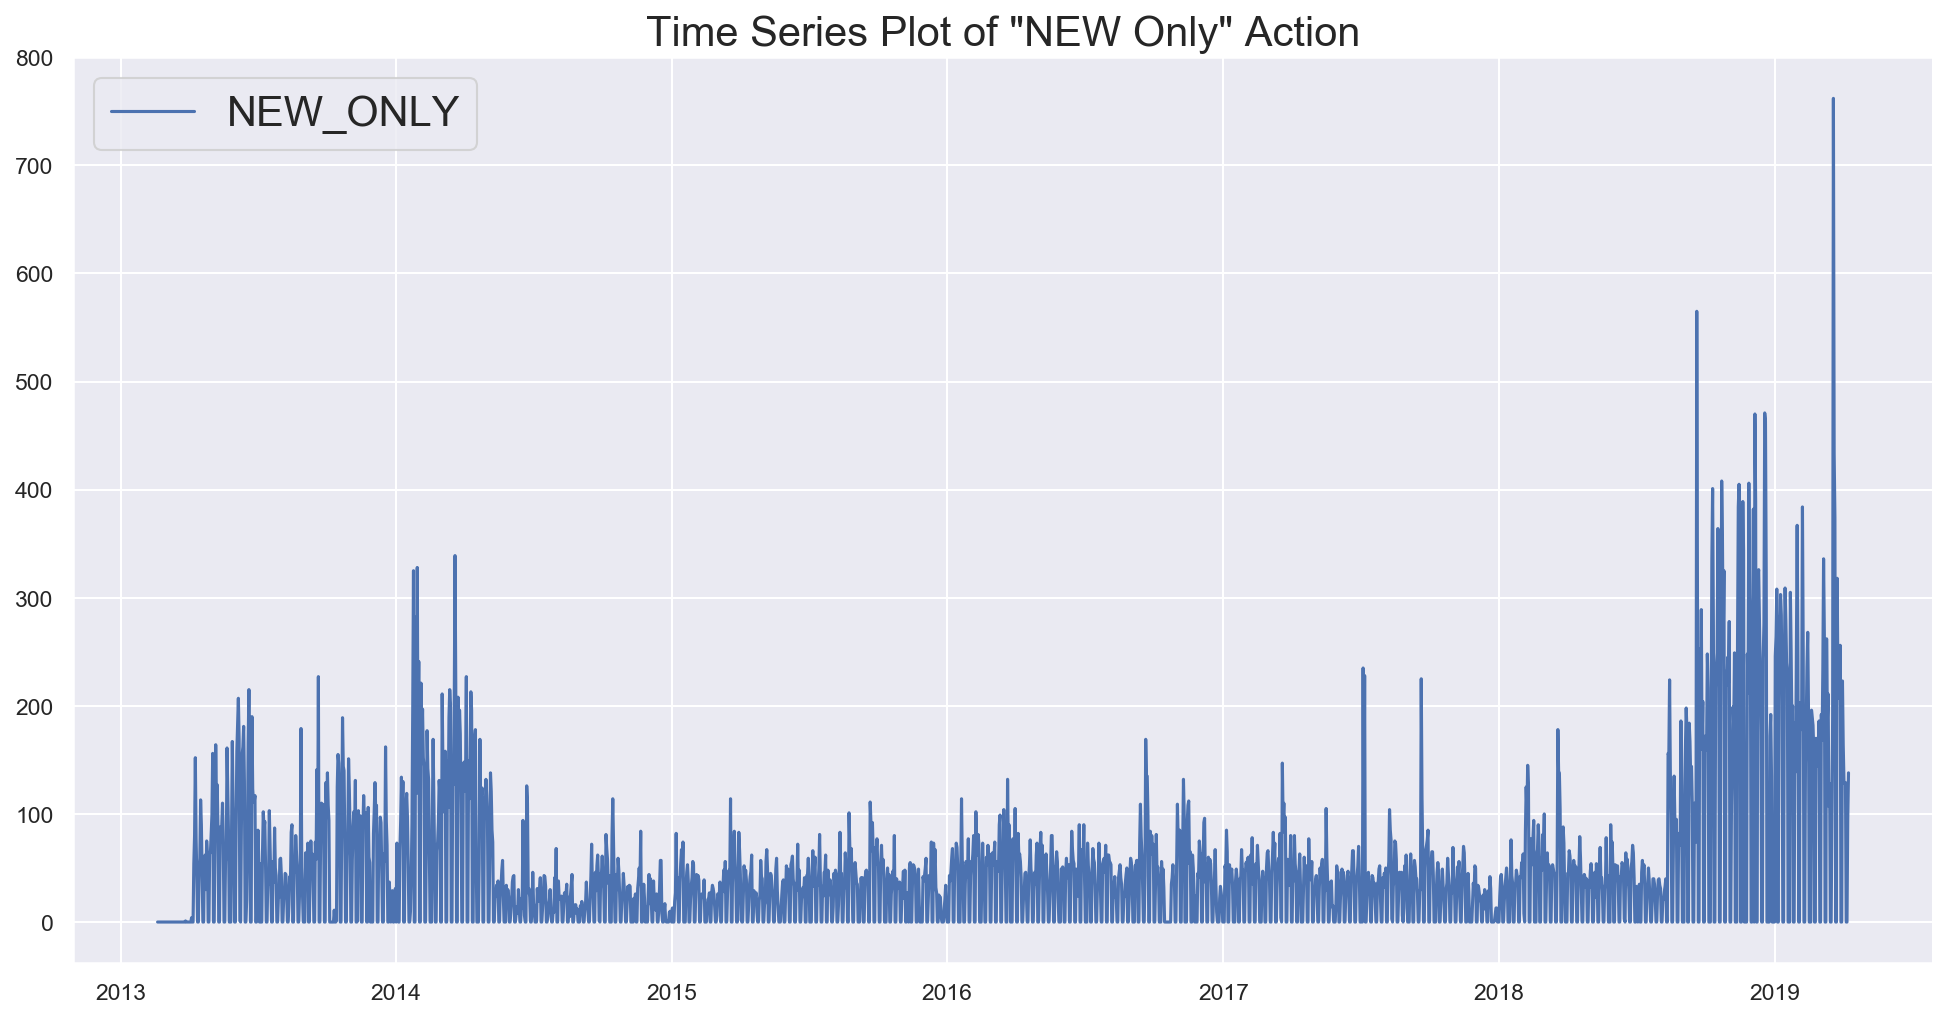

In [38]:
bucket_IG['NEW_ONLY'].plot()
#title of the plot
plt.title('Time Series Plot of "NEW Only" Action',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

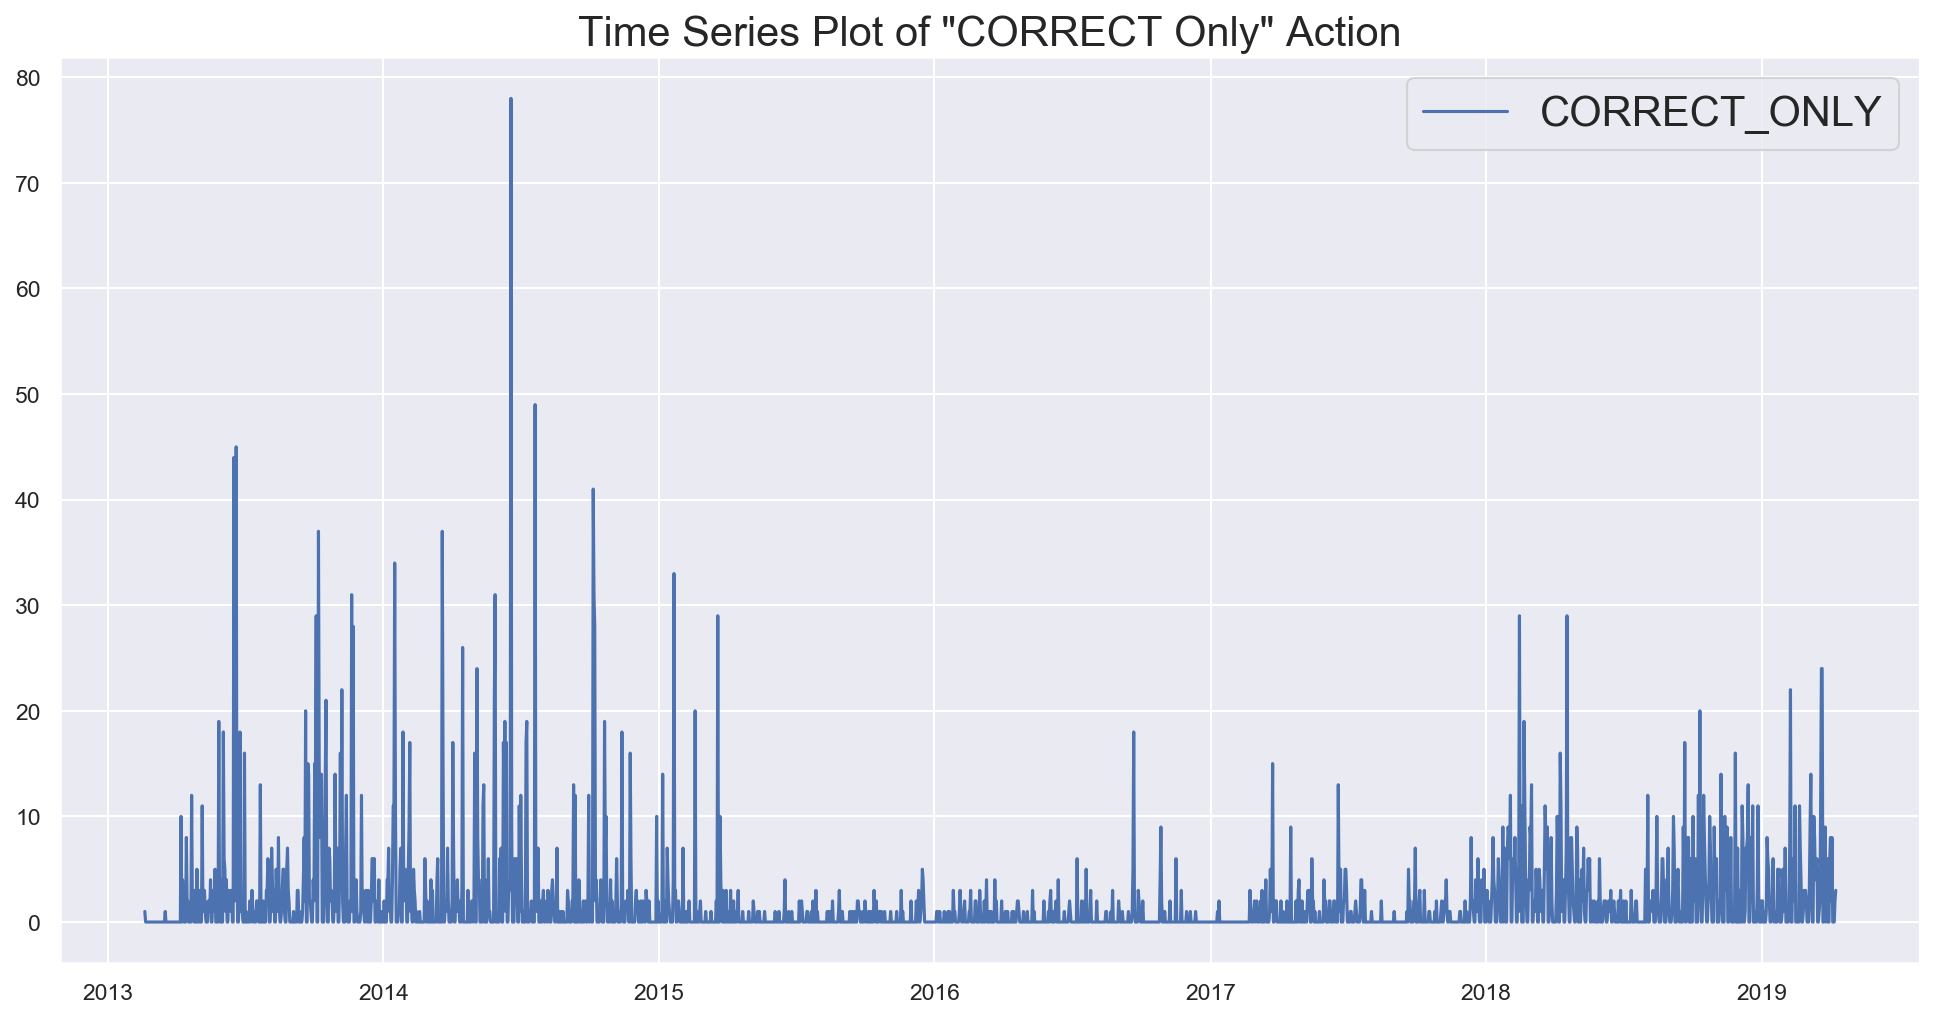

In [39]:
bucket_IG['CORRECT_ONLY'].plot()
#title of the plot
plt.title('Time Series Plot of "CORRECT Only" Action',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

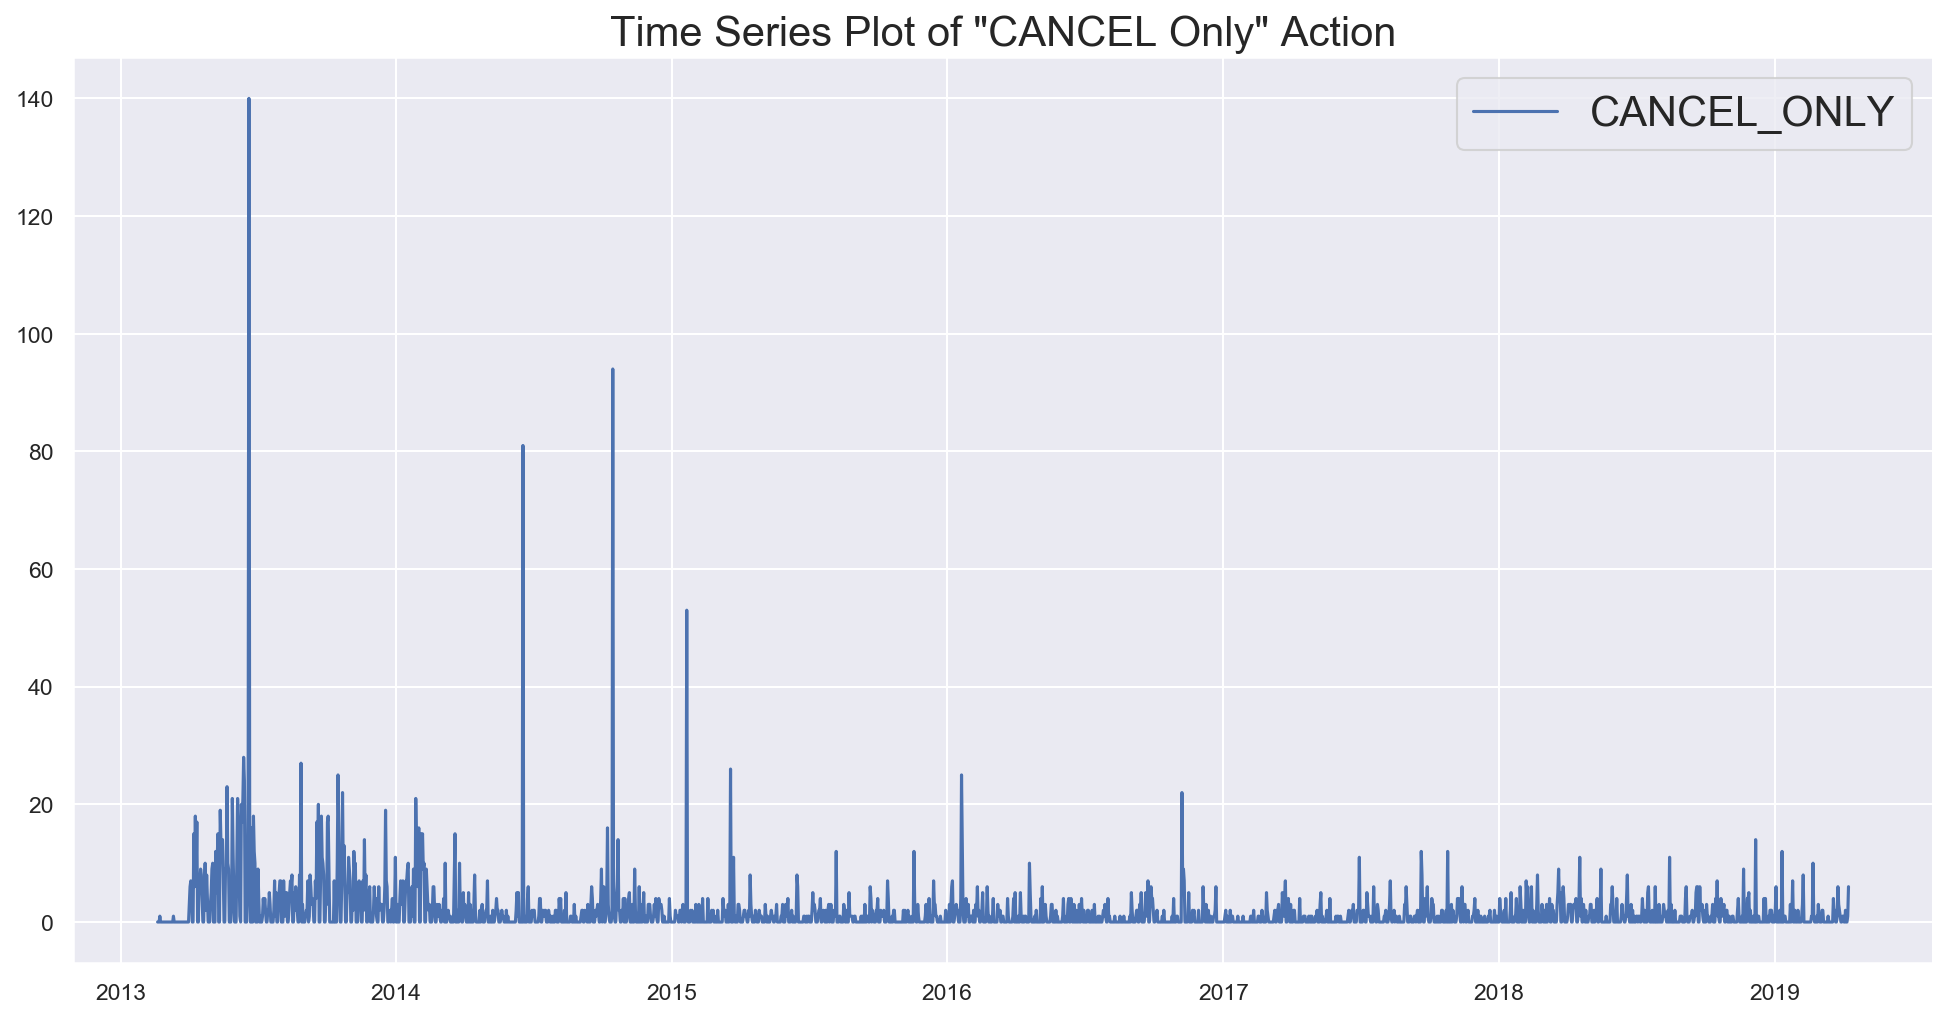

In [40]:
bucket_IG['CANCEL_ONLY'].plot()
#title of the plot
plt.title('Time Series Plot of "CANCEL Only" Action',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

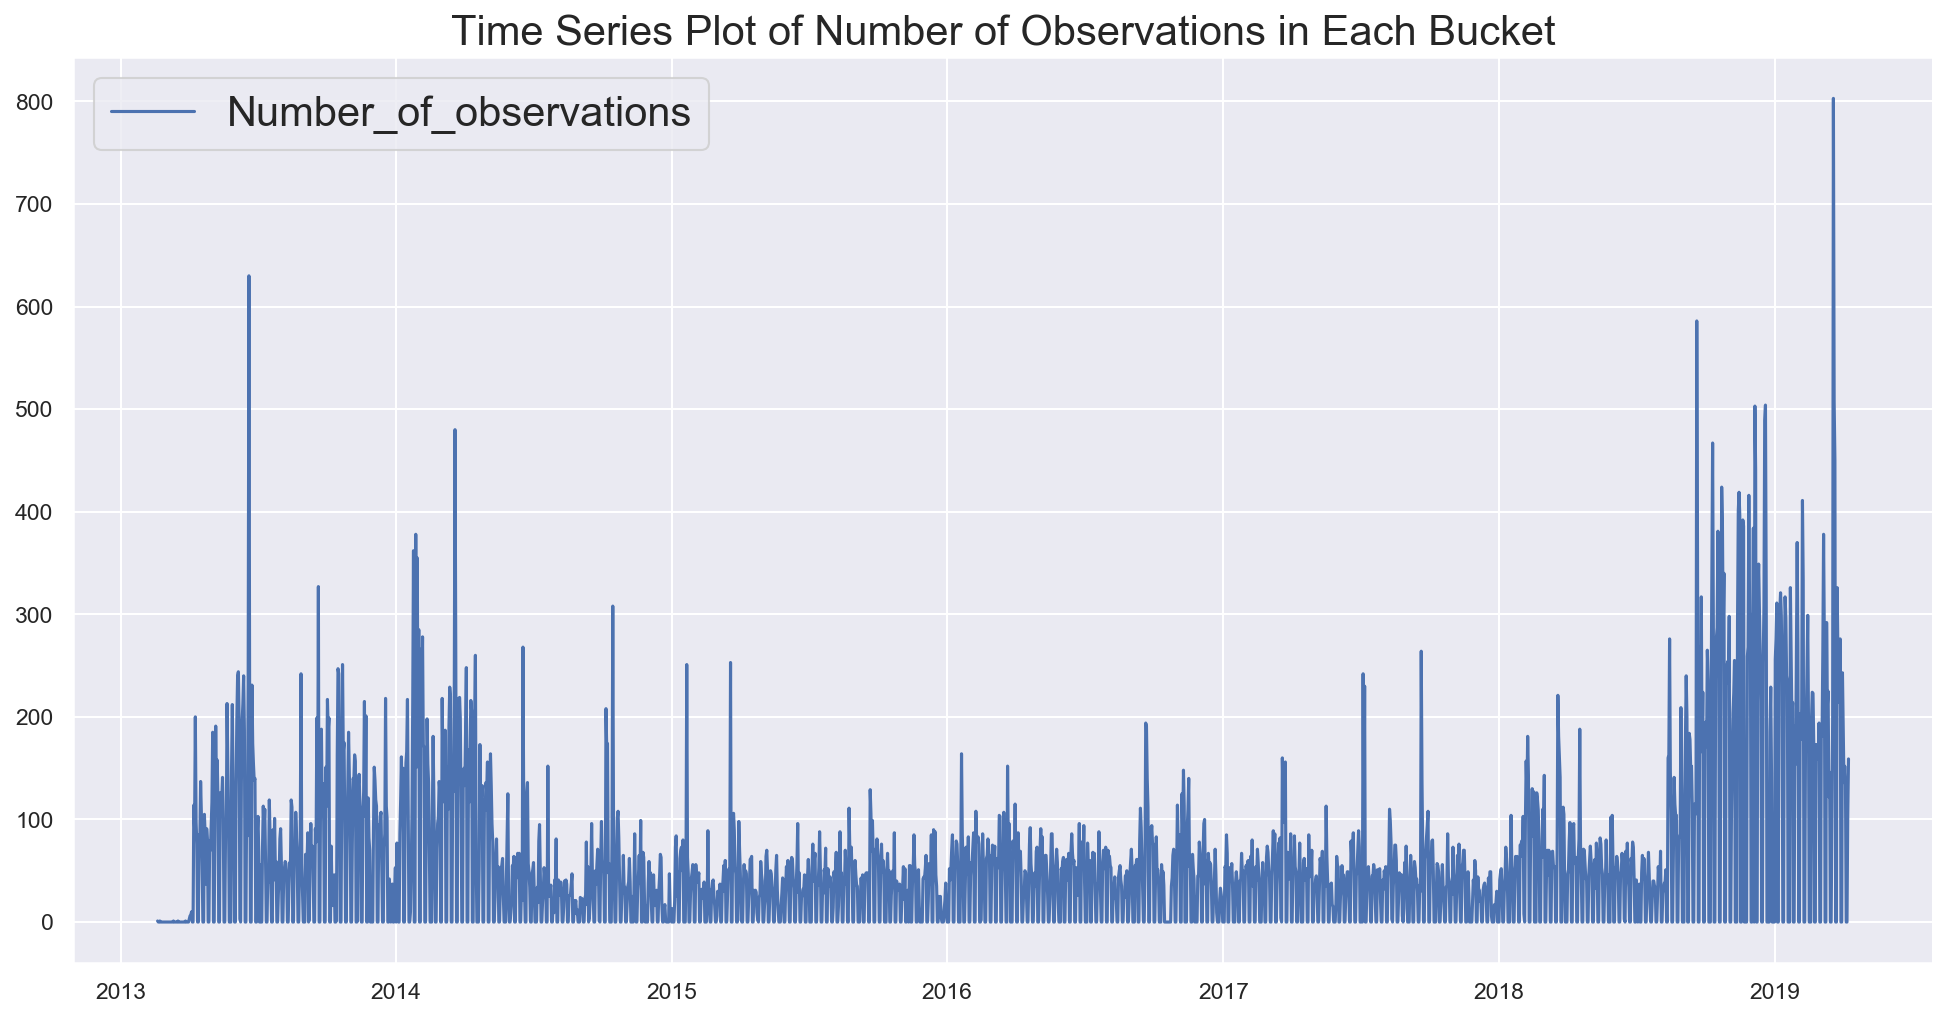

In [41]:
bucket_IG['Number_of_observations'].plot()
#title of the plot
plt.title('Time Series Plot of Number of Observations in Each Bucket',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

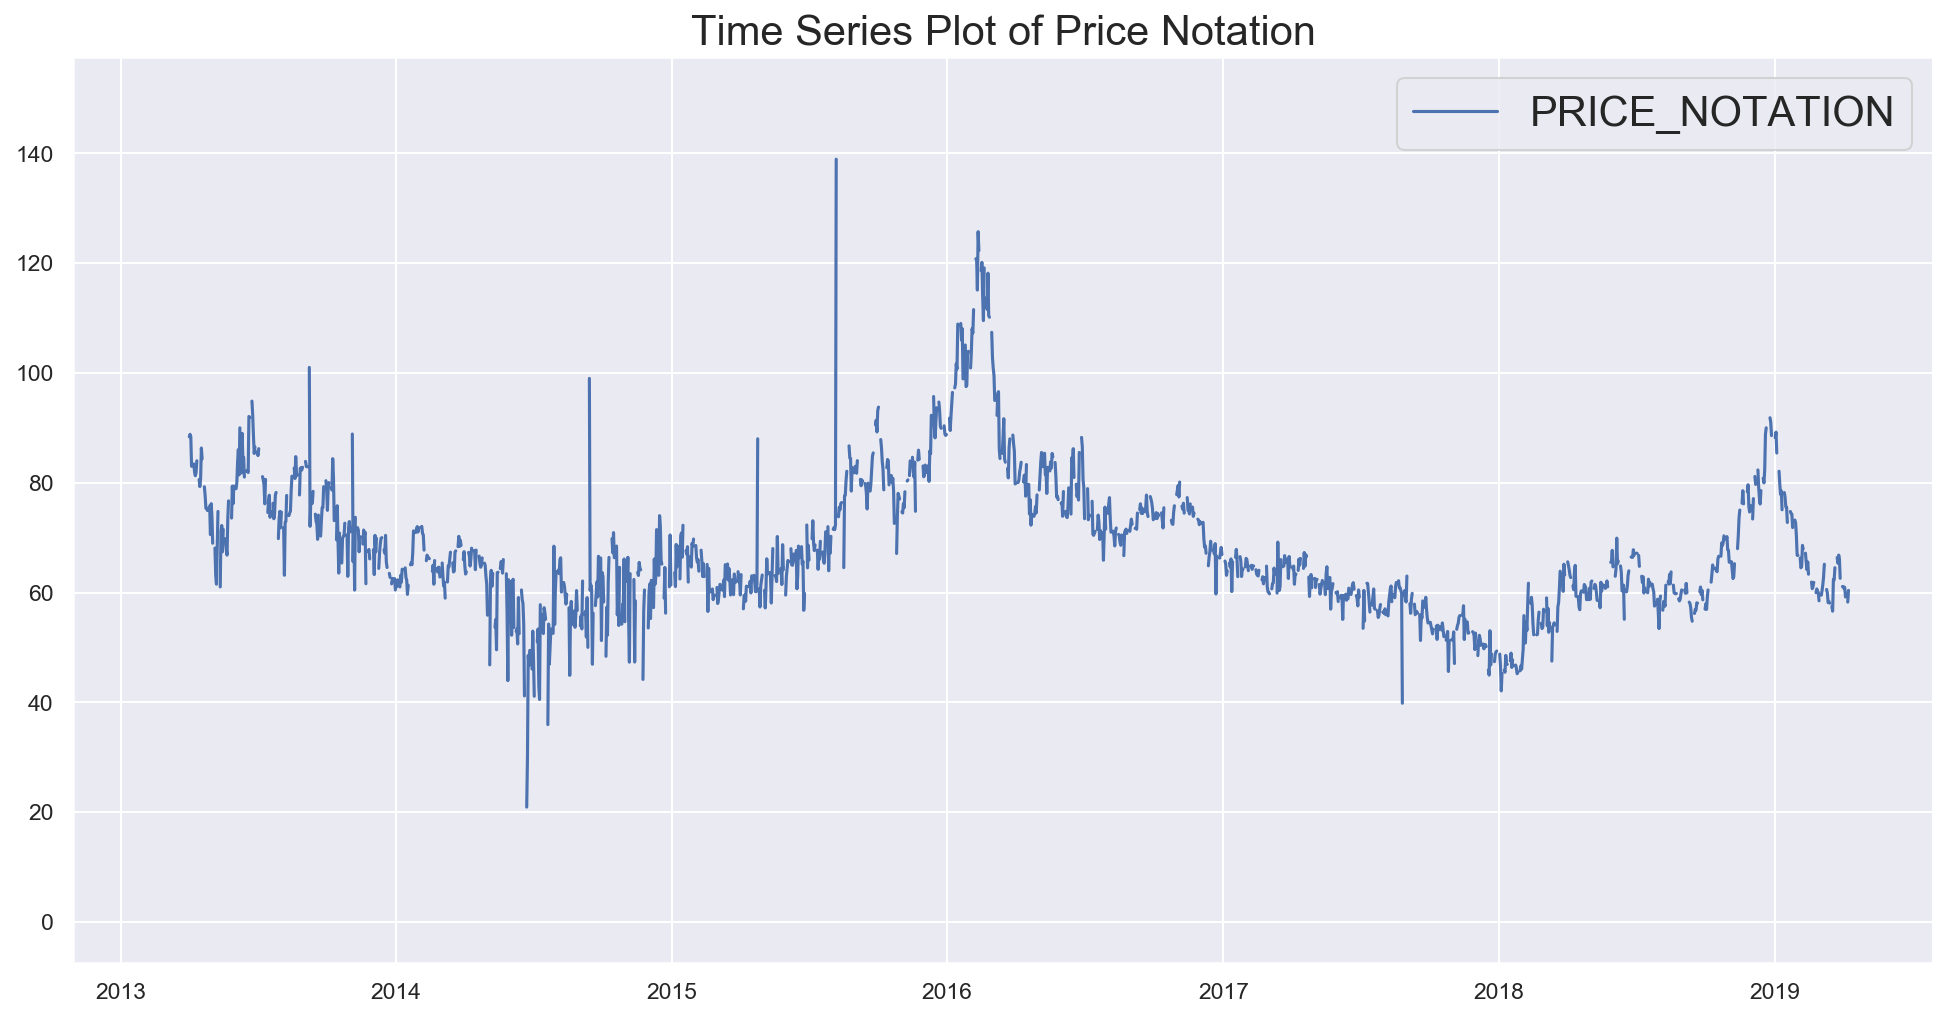

In [42]:
bucket_IG['PRICE_NOTATION'].plot()
#title of the plot
plt.title('Time Series Plot of Price Notation',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

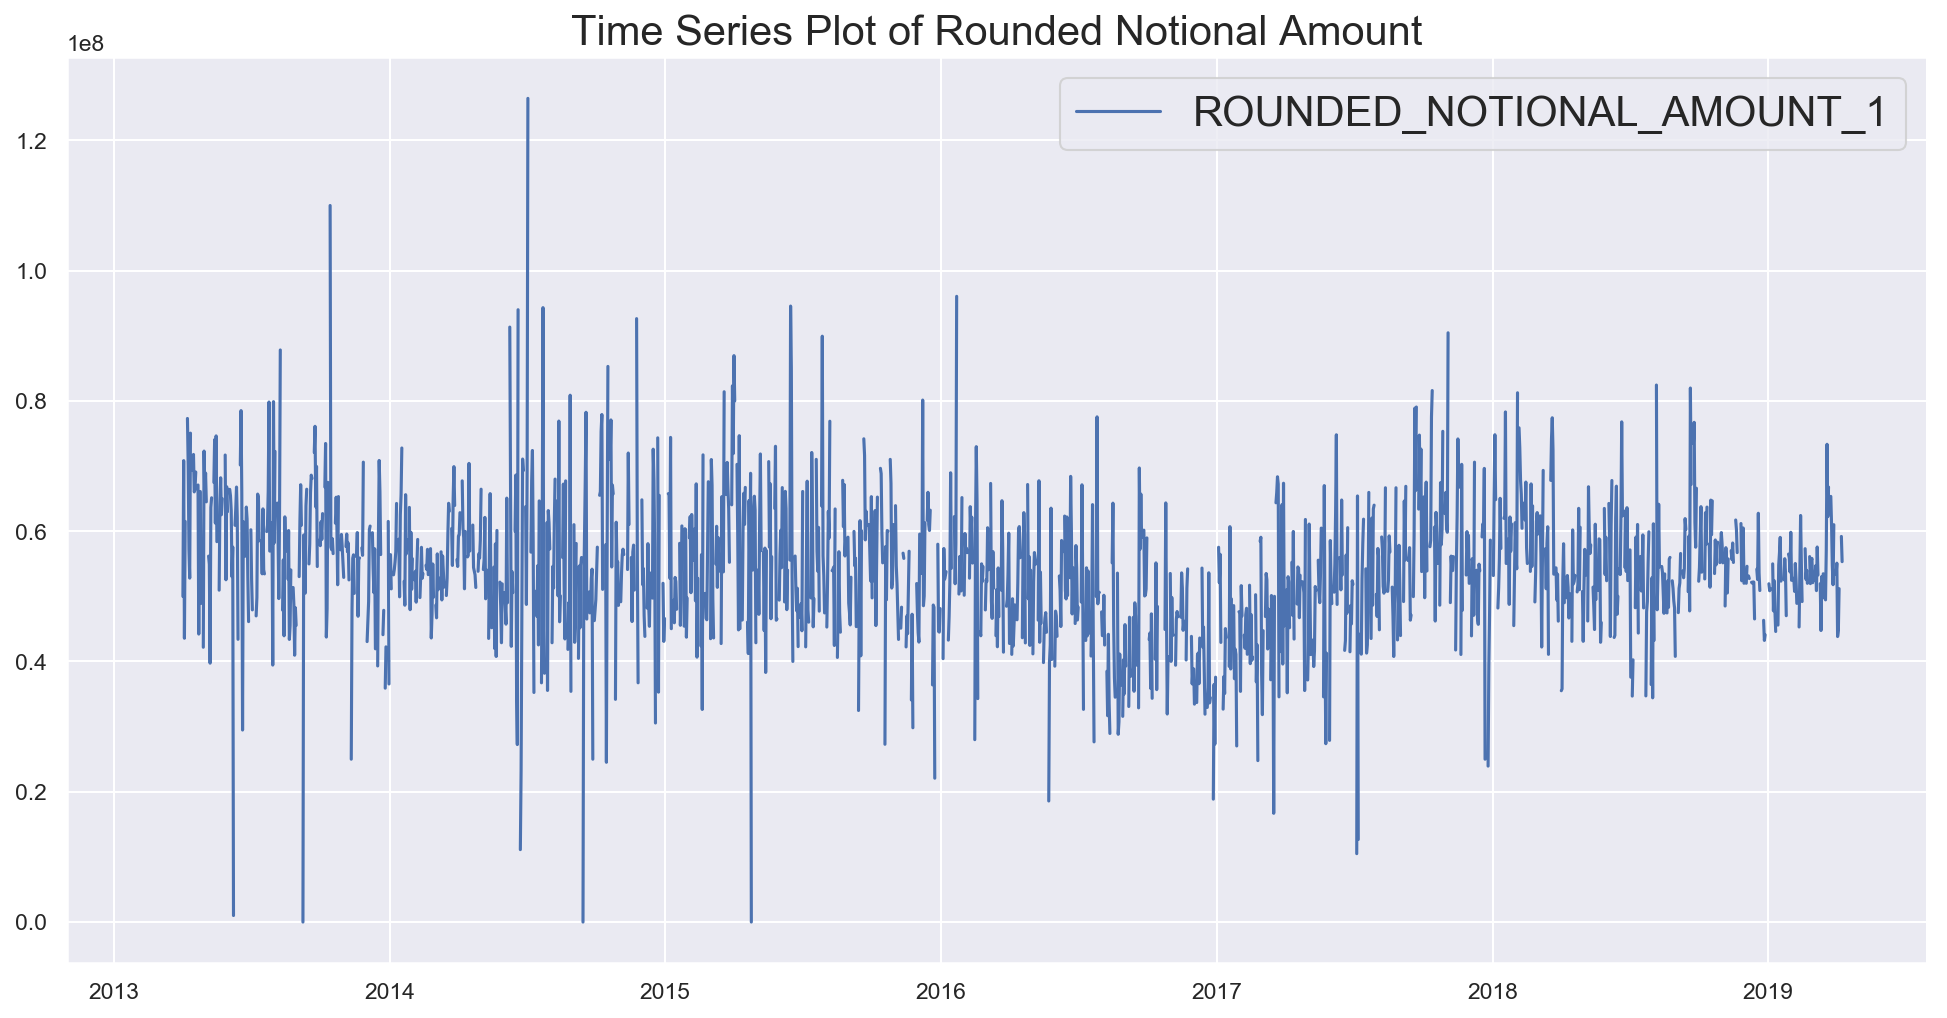

In [43]:
bucket_IG['ROUNDED_NOTIONAL_AMOUNT_1'].plot()
#title of the plot
plt.title('Time Series Plot of Rounded Notional Amount',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

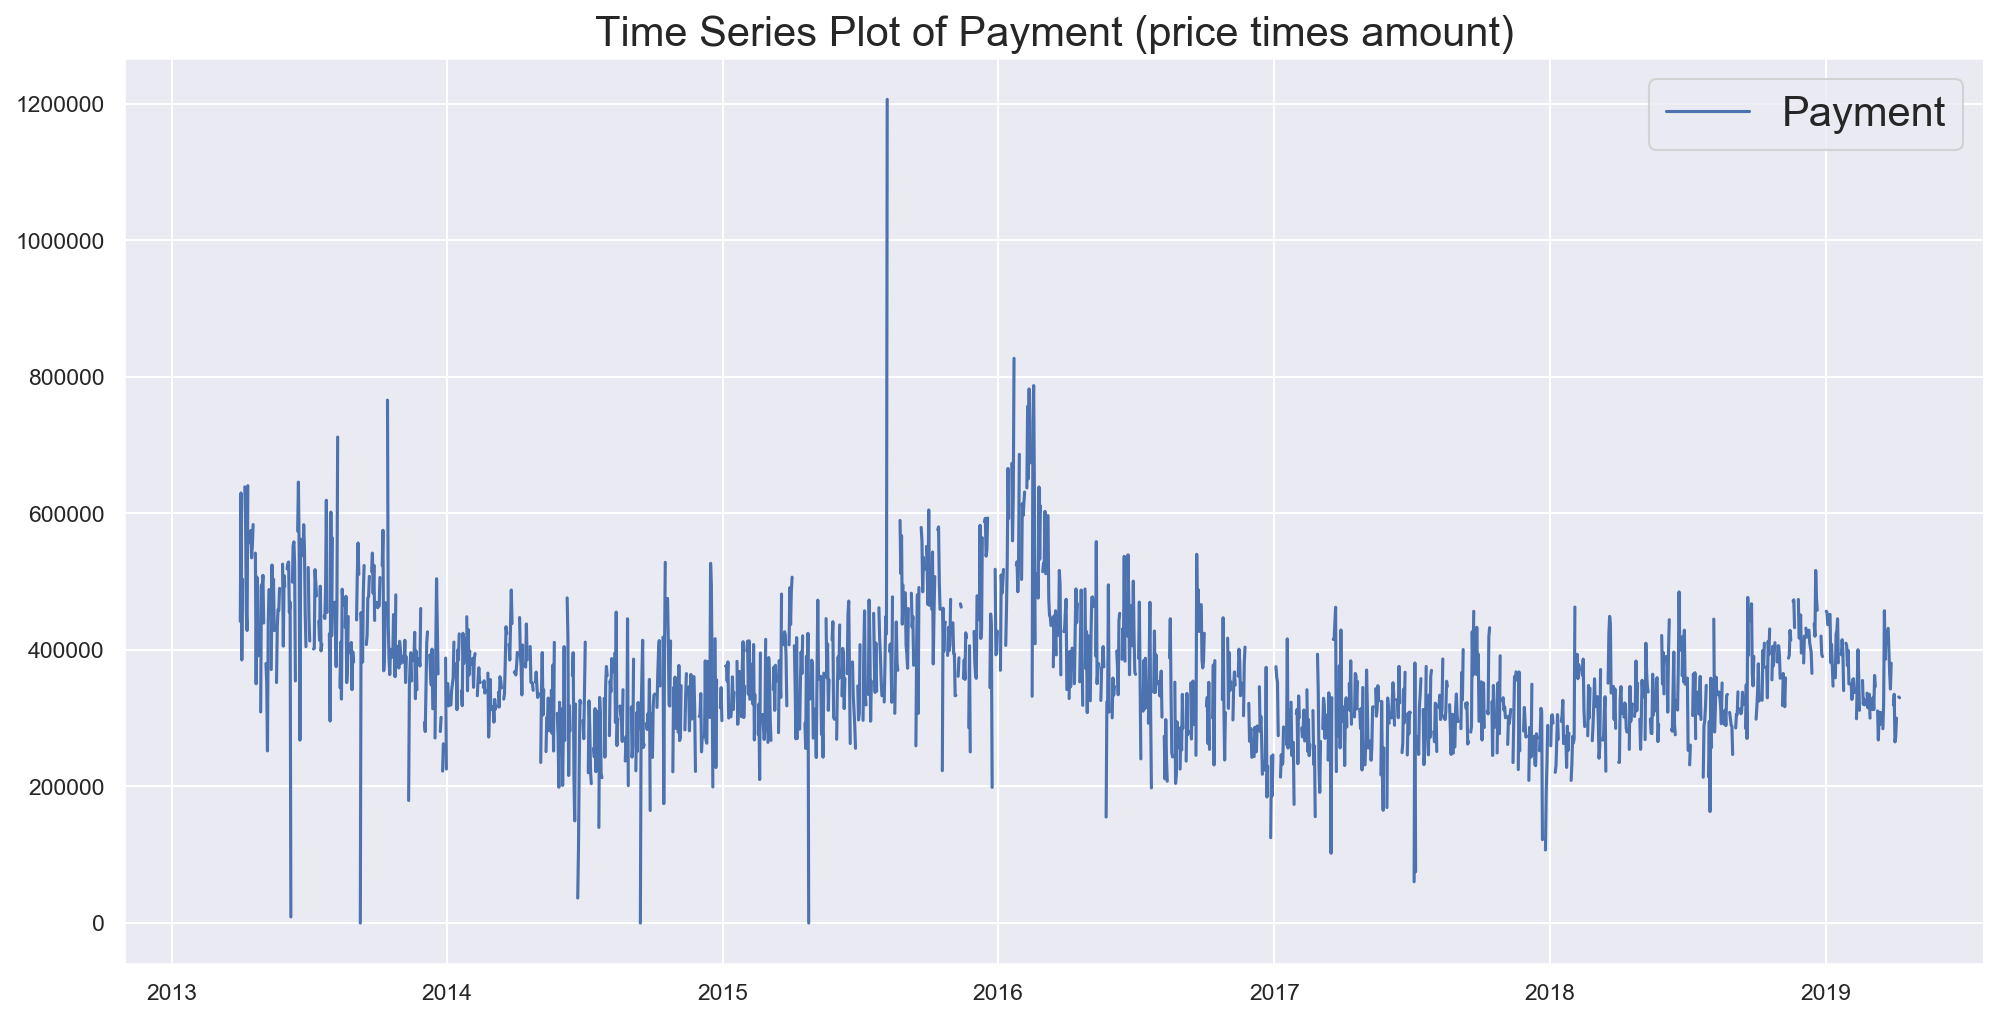

In [44]:
bucket_IG['Payment'].plot()
#title of the plot
plt.title('Time Series Plot of Payment (price times amount)',fontsize=20);

#title for the axes
plt.xlabel('',fontsize=15)
plt.ylabel('',fontsize=15)

plt.legend(fontsize=20)

From the notional amount plot and Payment plot, notice a abnormal value in 7/4/2018, which only have 1 record in the cleaned dataset, and the notional amount is 100000000+. Also, in other bucket also has 100000000+ values, they are averaged, but 7/4/18 only 1 record.

In [45]:
bucket_IG.to_csv("bucket_IG_large_before_standardize.csv", index = False)

## Data Standardization

In [34]:
# prepare data for standardization with mean 0 std 1
values = bucket_HY['PRICE_NOTATION'].values
values = values.reshape((len(values), 1))
# train the standardization
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(values)
normalized = scaler.transform(values)
bucket_HY['PRICE_NOTATION'] = normalized

In [35]:
values = bucket_HY['ROUNDED_NOTIONAL_AMOUNT_1'].values
values = values.reshape((len(values), 1))
# train the standardization
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(values)
normalized = scaler.transform(values)
bucket_HY['ROUNDED_NOTIONAL_AMOUNT_1'] = normalized

In [36]:
values = bucket_HY['Payment'].values
values = values.reshape((len(values), 1))
# train the standardization
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(values)
normalized = scaler.transform(values)
bucket_HY['Payment'] = normalized

In [37]:
# bucket_HY

In [38]:
bucket_HY.describe()

,PRICE_NOTATION,ROUNDED_NOTIONAL_AMOUNT_1,Payment,EXCEEDS_ROUNDED_NOTIONAL_AMOUNT,CANCEL,CORRECT,NEW,Number_of_observations,CANCEL_ONLY,CORRECT_ONLY,NEW_ONLY
count,1.508000e+03,1.508000e+03,1.508000e+03,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,-1.686529e-15,2.119584e-16,-8.039546e-17,2.861976,4.124944,2.090212,68.341903,74.484889,2.034732,2.090212,64.232747
std,1.000332e+00,1.000332e+00,1.000332e+00,8.957777,6.866914,4.167302,89.561620,96.048564,4.224324,4.167302,85.871814
min,-3.052605e+00,-2.886499e+00,-2.412576e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.545054e-01,-6.340209e-01,-5.781274e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-9.517064e-02,-1.373829e-01,-1.651148e-01,1.000000,1.000000,0.000000,49.000000,53.000000,0.000000,0.000000,46.000000
75%,2.843077e-03,4.453775e-01,3.451475e-01,3.000000,6.000000,3.000000,86.000000,96.000000,2.000000,3.000000,80.000000
max,1.494863e+01,1.240564e+01,9.931394e+00,247.000000,73.000000,73.000000,729.000000,765.000000,56.000000,73.000000,709.000000


In [39]:
# change index from timestamp to normal index, and set timestamp as a column
#bucket_HY['EXECUTION_BUCKETS'] = bucket_HY.index

In [40]:
#bucket_HY = bucket_HY.reset_index(drop = True)

In [41]:
bucket_HY.to_csv("bucket_HY_large_after_standardize.csv", index = False)